In [1]:
library(glmnet)
library(matrixStats)
library(abind)
library(pracma)
library(matrixcalc)
library(TCA)
library(MCMCpack)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18


Attaching package: ‘pracma’

The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu

Loading required package: coda
Loading required package: MASS
##
## Markov Chain Monte Carlo Package (MCMCpack)
## Copyright (C) 2003-2019 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park
##
## Support provided by the U.S. National Science Foundation
## (Grants SES-0350646 and SES-0350613)
##

Attaching package: ‘MCMCpack’

The following object is masked from ‘package:matrixcalc’:

    vech

The following object is masked from ‘package:pracma’:

    procrustes



In [2]:
generate_params <- function(cont_her=TRUE,seed=1){
    set.seed(1)
    M = 200
    K = 4
    N = 5000
    pc_num = 2
    # cis_snps_nums = floor(runif(M, min = 150, max = 400))
    D = 250
    cis_snps_nums = array(D,M)
    sigma_g = 0.01
    sigma_z = 0.2
    
    if(cont_her){ # varing heribility across genes
        heritibility_cell_specific = do.call(rbind,lapply(1:K,function(x) seq(from = 0.1,to = 0.9,length.out=M)))
        heritibility_bulk = array(0.8,M)
        overlap = array(0.4,M)
        pslab = matrix(0.5,nrow=M,ncol=K)
    }else{ # varying overlap with the same heribility
        heritibility_cell_specific = matrix(0.5,nrow=K,ncol=M)
        heritibility_bulk = array(0.8,M)
        overlap = seq(from=0.5,to=0.9,length.out=M)
        pslab = matrix(0.5,nrow=M,ncol=K)
    }
    MAF = lapply(1:length(cis_snps_nums),function(x) runif(cis_snps_nums[x],min=0.1,max=0.5))
    id_name = sapply(1:N, function(x) paste('SAMPLE',toString(x),sep = ''))
    cell_type_name=sapply(1:K, function(x) paste('Cell_type',x,sep = ''))
    
    ### generate C1 and C2
    male = matrix(rbinom(N, 1, 0.5),nrow=N)
    smoking = matrix(rbinom(N, 2, 0.2),nrow=N)
    smoking = (smoking - min(smoking))/(max(smoking))
    age = matrix(sapply(sapply(rnorm(N,50,20), function(x) floor(x)), function(x)  if (x<0){x=20} else{x=x}),nrow=N) 
    age = (age-min(age))/(max(age)-min(age))
    c1 = scale(cbind(male, smoking, age))
    c2 = scale(matrix(rnorm(N*pc_num), nrow=N))
                            
    rownames(c1) = id_name
    colnames(c1) = c('male','smoking','age')
    rownames(c2) = id_name
    colnames(c2) = sapply(1:pc_num, function(x) paste('PC',toString(x),sep = ''))
    
    # cell type proportion, from the real data estimated
    W_alpha = c(26.553683792256,17.6621467979005,4.48671525658667,1.56874856517803,0.178797663350679)
    W_alpha = 50.4500920752719
    W_xsi = c(0.526335685426257,0.350091468050216,0.088933737720289,0.0310950585152043,0.00354405028803339)
    if(K <= length(W_alpha)){
        W = rdirichlet(N, W_alpha[1:K])
    }else{ #more cell type prop
        W = rdirichlet(N, runif(K, 0, 1))
    }
    colnames(W) = cell_type_name
    rownames(W) = id_name
    
    return(list(
        'M'=M,'K'=K,'N'=N,'pc_num'=pc_num,'D'=D,'id_name'=id_name,'cell_name'=cell_type_name,
        'her'=heritibility_cell_specific,'her_bulk'=heritibility_bulk,'overlap'=overlap,'pslab'=pslab,
        'MAF'=MAF,'c1'=c1,'c2'=c2,'W'=W,'sigma_g'=sigma_g,'sigma_z'=sigma_z))
}

In [3]:
one_gene <- function(par,g,seed=1){
    set.seed(seed)
    cell_type = par$K
    n_snps = par$D
    her = par$her[,g]
    pslab = par$pslab[g,]
    overlap = par$overlap[g]
    maf = par$MAF[[g]]
    dummy_var = 10

    # Please guarantee that Gene Expression Variance is 1 across ge in cell
    rmask = do.call(rbind,lapply(1:cell_type,function(x) rbinom(n_snps,1,1-pslab[x])))
    sigma_beta_ = sqrt(her/n_snps/pslab)
    beta_ = do.call(rbind,lapply(1:cell_type,function(x) rnorm(n_snps,mean=dummy_var,sd=sigma_beta_[x])))
    beta = beta_*rmask
    # find overlap

    sorted_effect_size = t(apply(beta,1,function(x) sort(x,decreasing=TRUE)))
    full_effect_size = sum(as.integer(apply(sorted_effect_size,2,function(x) (!0 %in% x))))
    sorted_effect_size[sorted_effect_size>dummy_var/2] = sorted_effect_size[sorted_effect_size>dummy_var/2]-dummy_var
    overlap_num = floor(n_snps*overlap)
    #print(paste('technical overlap',overlap,sep=','))
    if(full_effect_size<overlap_num){
        overlap_num = full_effect_size
    }
    #print(paste('actual techinal overlap',overlap_num/n_snps))
    full_effect_size = t(apply(sorted_effect_size[,1:overlap_num],1,function(x) sample(x,overlap_num)))
    other_effect_size = t(apply(sorted_effect_size[,(overlap_num+1):dim(sorted_effect_size)[2]],1,function(x) sample(x)))

    beta = cbind(full_effect_size,other_effect_size)
    act_lap = sum(apply(beta,2,function(x) (!0%in%x)))/n_snps
    #print(paste('final overlap',act_lap),sep=',')

    X = t(do.call(rbind,lapply(1:n_snps,function(x) rbinom(par$N,2,maf[x]))))
    colnames(X) = sapply(1:n_snps, function(x) paste('G',g,'_SNP',toString(x),sep = ''))
    rownames(X) = par$id_name
    X = scale(X)
    # enforce variance of samples by adjusting sd of gamma_c1
    beta = do.call(rbind,
                      lapply(1:cell_type,function(x) beta[x,]*(sqrt(her[x])/sd(X %*% beta[x,]))))

    mu_z = X%*%t(beta)
    res_her = 1-her
    noise_z = par$sigma_z*par$sigma_z
    stopifnot(noise_z<min(res_her))
    par$sigma_z = sqrt(res_her)
    epsilon_z = array(rnorm(par$N*cell_type,mean=0,sd=par$sigma_z), c(par$N,cell_type))
    epsilon_z = apply(epsilon_z,2,function(x) x*par$sigma_z/sd(x))
    # do not need to enforce sparsity on c1
    her_c1 = res_her - noise_z
    sd_gamma_c1 = sqrt(her_c1/dim(par$c1)[2])
    gamma_c1 = do.call(rbind,lapply(1:cell_type,function(x) rnorm(dim(par$c1)[2],mean=0,sd=sd_gamma_c1[x])))
    # enforce variance of samples by adjusting sd of gamma_c1
    gamma_c1 = do.call(rbind,
                      lapply(1:cell_type,function(x) gamma_c1[x,]*(sqrt(her_c1[x])/sd(par$c1 %*% gamma_c1[x,]))))
    c1_gamma = par$c1 %*% t(gamma_c1)

    Z = epsilon_z + mu_z# + c1_gamma
    rownames(Z) = par$id_name
    colnames(Z) = par$cell_name
    
    ### Generate Gene expressions
    G = rowSums((par$W)*Z)
    res_var = 1/par$her_bulk[g]-1
    noise_g = par$sigma_g*par$sigma_g
    stopifnot(noise_g<res_var)
    epsilon_G = rnorm(par$N,mean=0,sd=par$sigma_g)
    
    sd_gamma_c2 = sqrt((res_var-noise_g)/par$pc_num)
    gamma_c2 = matrix(rnorm(par$pc_num,mean=0,sd=sd_gamma_c2),nrow=par$pc_num,ncol=1)
    c2_gamma = par$c2 %*% gamma_c2
    
    #G = t(G + c2_gamma + epsilon_G)
    #G = t(G+epsilon_G)
    G = t(G)
    colnames(G) <- par$id_name
    rownames(G) <- paste('gene',g,sep='_')
    G = as.data.frame(G)
    
    return(list('X'=X,'beta'=beta,'gamma_c1'=t(gamma_c1),
                'gamma_c2'=gamma_c2,'Z'=Z,'G'=G,
               'theo_lap'=overlap,'act_lap'=act_lap))
}
                                    
#data = one_gene(par=params,1)

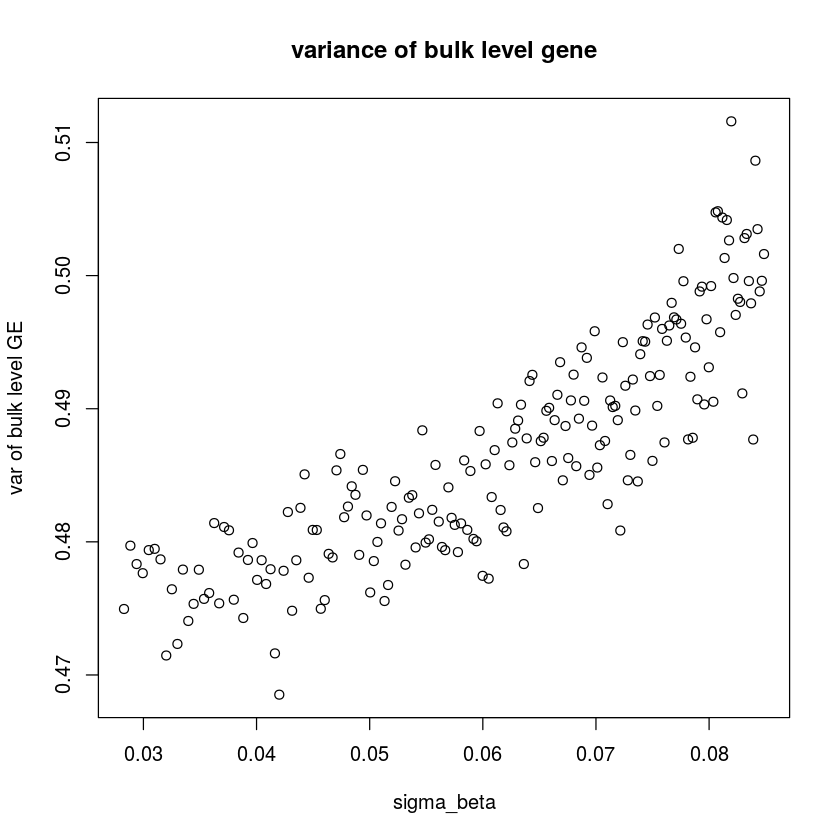

In [4]:
params = generate_params(cont_her=TRUE,seed=1)
data = lapply(1:params$M,function(x) one_gene(par=params,x))
mean_G2 = do.call(rbind,lapply(1:params$M,function(x) mean(unlist(data[[x]]$G))))
mean_G1 = do.call(rbind,lapply(1:params$M,function(x) mean((data[[x]]$G)^2)))
var_g_real = do.call(rbind,lapply(1:params$M,function(x) var(unlist(data[[x]]$G))))
sum_expec_weight_sq = sum(apply(params$W^2,2,mean))
var_g_theo = (params$sigma_g^2+sum_expec_weight_sq)
# As variance of beta goes up, so does bulk level variance
sigma_beta_ = sqrt(params$her[1,]/params$D/params$pslab[,1])
plot(sigma_beta_,mean_G1,xlab='sigma_beta',ylab='var of bulk level GE')
title('variance of bulk level gene')

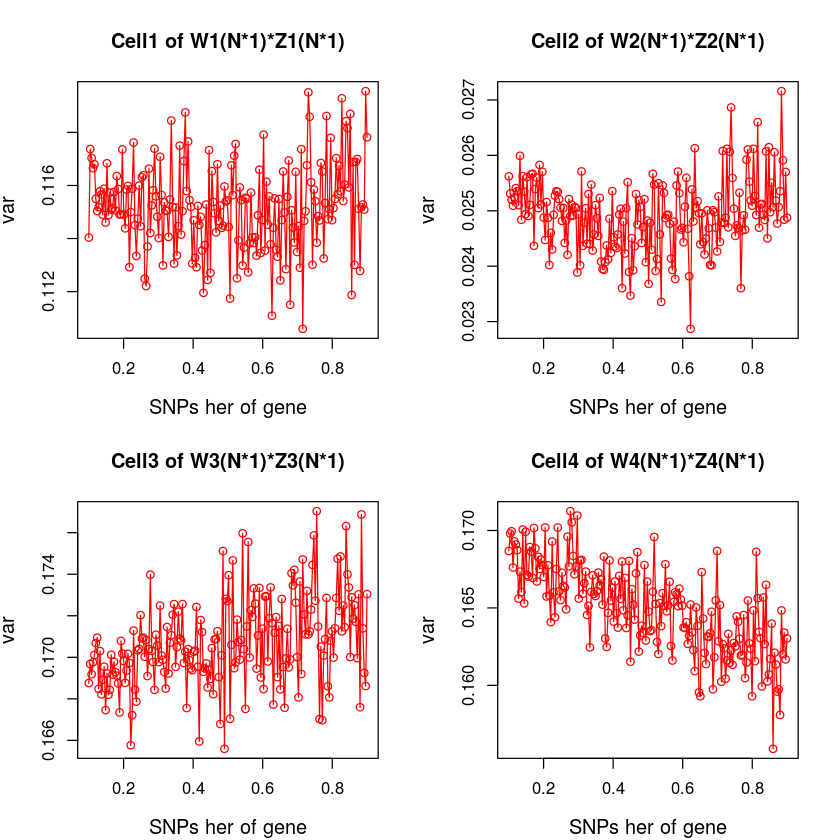

In [5]:
# The W*Z terms in the variance.
wz1 = do.call(rbind,lapply(1:params$M,function(x) var(params$W[,1]*data[[x]]$Z[,1])))
wz2 = do.call(rbind,lapply(1:params$M,function(x) var(params$W[,2]*data[[x]]$Z[,2])))
wz3 = do.call(rbind,lapply(1:params$M,function(x) var(params$W[,3]*data[[x]]$Z[,3])))
wz4 = do.call(rbind,lapply(1:params$M,function(x) var(params$W[,4]*data[[x]]$Z[,4])))
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
plot(params$her[1,],wz1,xlab='SNPs her of gene',
     ylab='var',cex.lab=1.2,yaxs='r',type='o',col='red')
title(main='Cell1 of W1(N*1)*Z1(N*1)')
plot(params$her[1,],wz2,xlab='SNPs her of gene',
     ylab='var',cex.lab=1.2,yaxs='r',type='o',col='red')
title(main='Cell2 of W2(N*1)*Z2(N*1)')
plot(params$her[1,],wz3,xlab='SNPs her of gene',
     ylab='var',cex.lab=1.2,yaxs='r',type='o',col='red')
title(main='Cell3 of W3(N*1)*Z3(N*1)')
plot(params$her[1,],wz4,xlab='SNPs her of gene',
     ylab='var',cex.lab=1.2,yaxs='r',type='o',col='red')
title(main='Cell4 of W4(N*1)*Z4(N*1)')

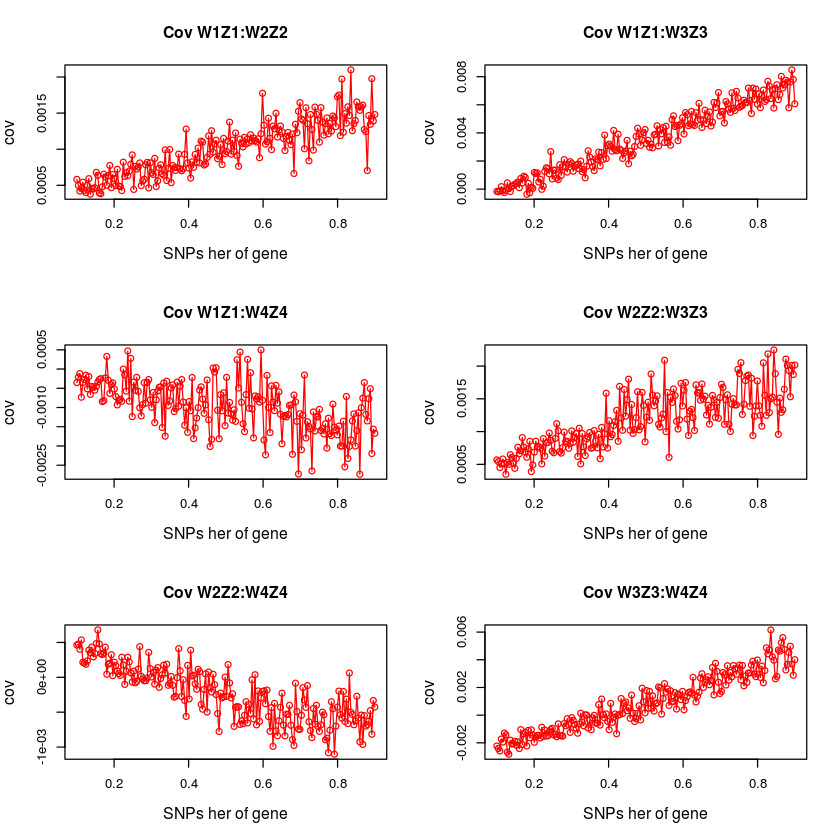

In [6]:
# The Cov[W1(*)Z1],W2(*)Z2] terms in the variance.
par(mfrow=c(3,2))
cov = matrix(0,nrow=6,ncol=params$M)
ticker = 1
for(i in 1:3){
    for(j in (i+1):4){
        cov[ticker,] = do.call(rbind,
                      lapply(1:params$M,function(x) cov(params$W[,i]*data[[x]]$Z[,i],
                                                   params$W[,j]*data[[x]]$Z[,j])))
        plot(params$her[1,],cov[ticker,],xlab='SNPs her of gene',
            ylab='cov',cex.lab=1.2,yaxs='r',type='o',col='red')
        title(main=paste('Cov W',i,'Z',i,':W',j,'Z',j,sep=''))
        ticker = ticker+1
    }
}

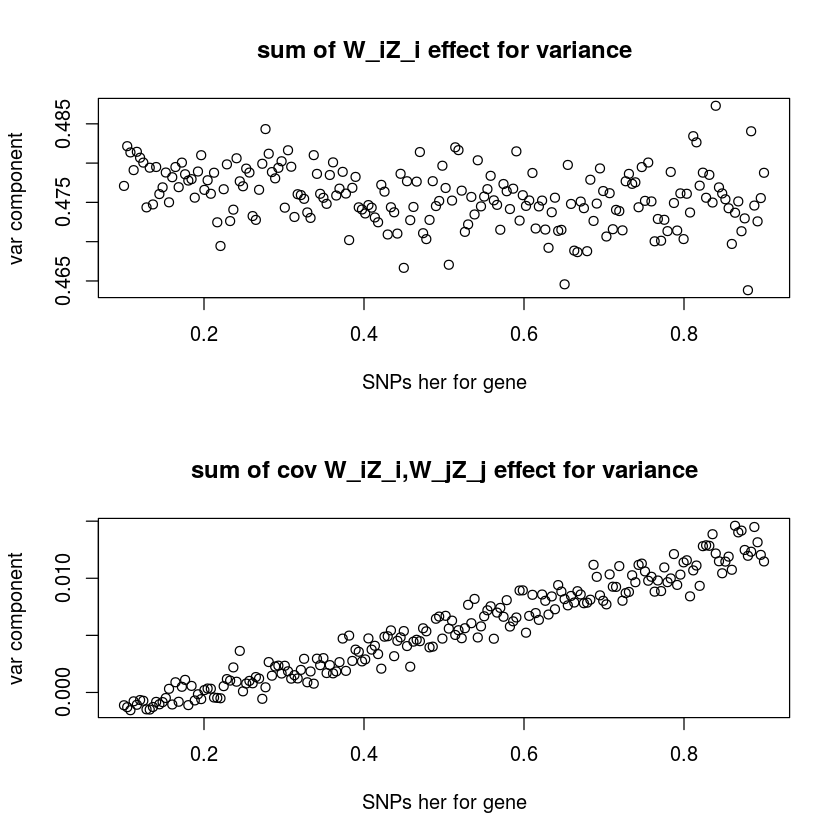

In [7]:
sum_of_ind_effect = apply(t(cbind(wz1,wz2,wz3,wz4)),2,sum)
sum_of_cov_effect = apply(cov,2,sum)

par(mfrow=c(2,1))
plot(params$her[1,],sum_of_ind_effect,xlab='SNPs her for gene',ylab='var component')
title(main='sum of W_iZ_i effect for variance')
plot(params$her[1,],sum_of_cov_effect,xlab='SNPs her for gene',ylab='var component')
title(main='sum of cov W_iZ_i,W_jZ_j effect for variance')

In [8]:
# What cause the covariance to change with beta sigma?
# It turned out that it is not the second term in the covariance term
# E[w1(*)Xbeta1]' *E[w3(*)Xbeta3] is a number. But 200 genes.
cov13_21=t(do.call(rbind,lapply(1:params$M,function(x) mean(params$W[,1]*data[[x]]$Z[,1]))))
cov13_22=t(do.call(rbind,lapply(1:params$M,function(x) mean(params$W[,3]*data[[x]]$Z[,3]))))
cov13_2 = cov13_21*cov13_22
# print out cov13_2 for this to check

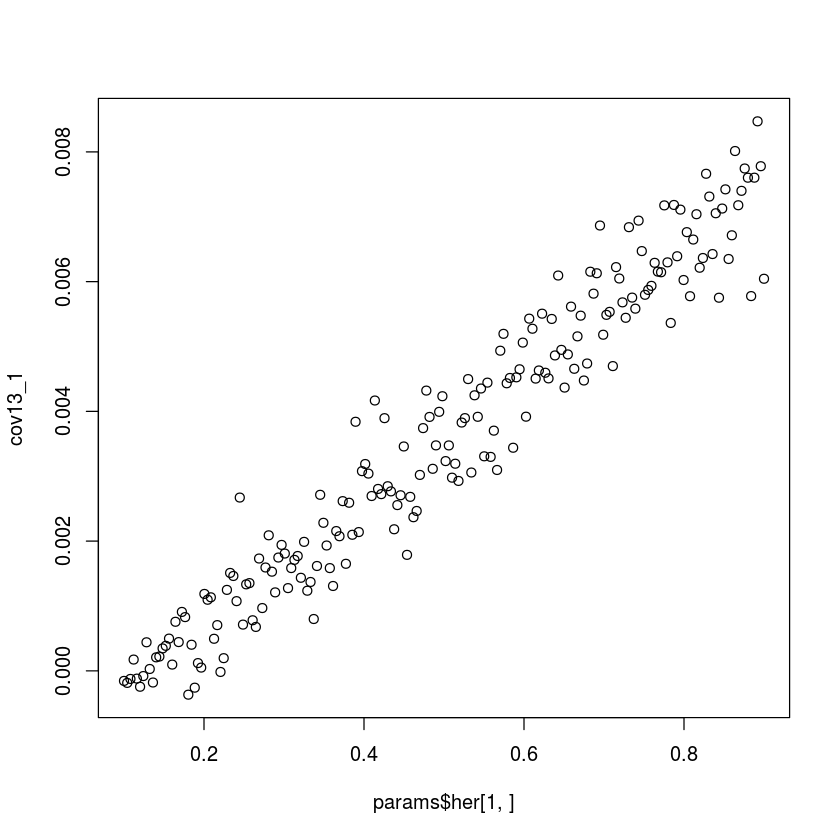

In [9]:
# It turned out that E[(W1(*)Z1)'*(W3(*)Z3)]
cov13_1 = lapply(1:200,function(x) 
    mean((params$W[,1]*data[[x]]$Z[,1])*(params$W[,3]*data[[x]]$Z[,3])))
plot(params$her[1,],cov13_1)

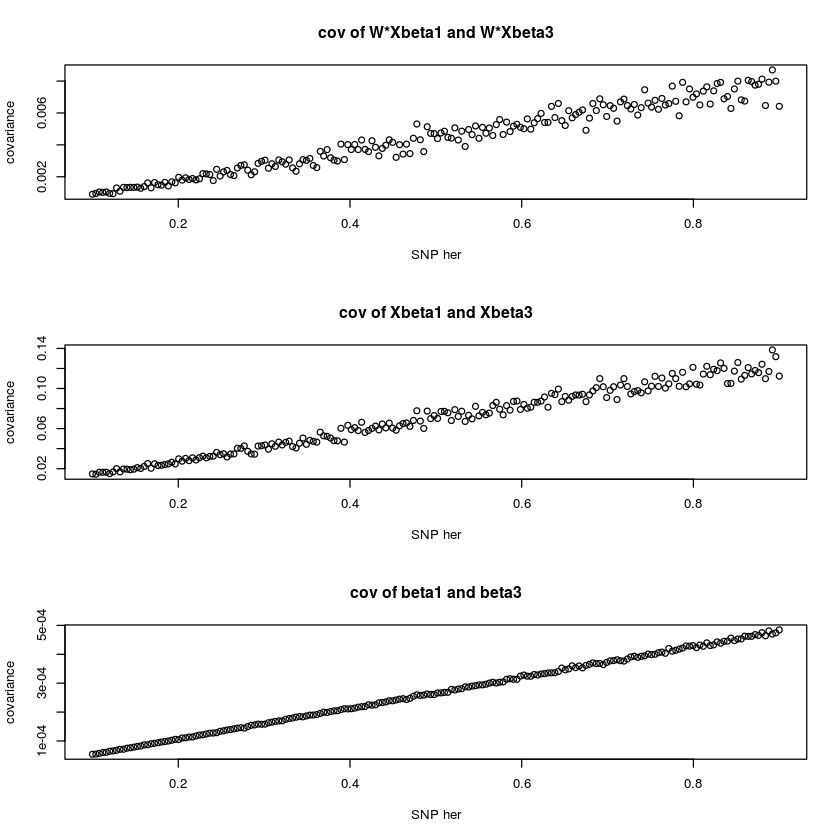

In [10]:
cov13_xbeta = lapply(1:200,function(x) 
    mean((params$W[,1]*(data[[x]]$X %*% data[[x]]$beta[1,]))*
         (params$W[,3]*(data[[x]]$X %*% data[[x]]$beta[3,]))))
cov13_xbeta_pure = lapply(1:200,function(x) 
    mean(((data[[x]]$X %*% data[[x]]$beta[1,]))*
         ((data[[x]]$X %*% data[[x]]$beta[3,]))))
cov13_beta_pure = lapply(1:200,function(x) 
    mean(((data[[x]]$beta[1,]))*
         ((data[[x]]$beta[3,]))))
#plot(params$her[1,],cov13_xbeta)
# how come it is the cross entropy of the c1 gamma that is contributing?
# cov13_c1gamma = lapply(1:200,function(x) 
#     mean((params$W[,1]*(params$c1 %*% data[[x]]$gamma_c1[,1]))*
#          (params$W[,3]*(params$c1 %*% data[[x]]$gamma_c1[,3]))))
#plot(params$her[1,],cov13_c1gamma)
# This could be further explained by the covariance of c1 gamma_c1
# cov13_c1gamma_pure = lapply(1:200,function(x) 
#     mean(((params$c1 %*% data[[x]]$gamma_c1[,1]))*
#          ((params$c1 %*% data[[x]]$gamma_c1[,3]))))
#plot(params$her[1,],cov13_c1gamma_pure)
                            
par(mfrow=c(3,1))
plot(params$her[1,],cov13_xbeta,xlab='SNP her',ylab='covariance')
title(main='cov of W*Xbeta1 and W*Xbeta3')
plot(params$her[1,],cov13_xbeta_pure,xlab='SNP her',ylab='covariance')
title(main='cov of Xbeta1 and Xbeta3')
plot(params$her[1,],cov13_beta_pure,xlab='SNP her',ylab='covariance')
title(main='cov of beta1 and beta3')
# plot(params$her[1,],cov13_c1gamma,xlab='SNP her',ylab='covariance')
# title(main='cov of W*C1gamma1 and W*C1gamma3')
# plot(params$her[1,],cov13_c1gamma_pure,xlab='SNP her',ylab='covariance')
# title(main='cov of C1gamma1 and C1gamma3')
# gamma_cor = do.call(rbind,lapply(1:200,function(x) cov(data[[x]]$gamma_c1[,1],data[[x]]$gamma_c1[,3])))
# plot(params$her[1,],gamma_cor,xlab='SNP her',ylab='covariance')
# title(main='cov of gamma1 and gamma3')

In [54]:
# Good correlation found here
est_xbeta = data[[1]]$X %*% t(data[[1]]$beta)
cov(est_xbeta)
cov_beta = cov(t(data[[1]]$beta))
cov_beta*params$D

0.100000000,0.010846584,0.014778307,-0.000742504
0.010846584,0.100000000,0.007596105,-0.001140731
0.014778307,0.007596105,0.100000000,0.009216344
-0.000742504,-0.001140731,0.009216344,0.100000000


0.103905084,0.0097778206,0.013138640,-0.0010394911
0.009777821,0.1006379930,0.007245365,-0.0005766811
0.013138640,0.0072453651,0.102877248,0.0096526371
-0.001039491,-0.0005766811,0.009652637,0.1005968119


In [60]:
est_cgamma = params$c1 %*% data[[2]]$gamma_c1
cov(est_cgamma)
cov_gamma = cov(data[[2]]$gamma_c1)
cov_gamma*dim(params$c1)[2]

0.8559799,0.1010206,-0.3256510,-0.7129516
0.1010206,0.8559799,0.7155097,0.2568533
-0.3256510,0.7155097,0.8559799,0.6612344
-0.7129516,0.2568533,0.6612344,0.8559799


0.93047772,0.4540844,0.07109835,-0.46466967
0.45408438,1.0010730,0.56952937,-0.14697081
0.07109835,0.5695294,0.37240538,0.01924431
-0.46466967,-0.1469708,0.01924431,0.24021893


In [85]:
cov(data[[1]]$Z)

,Cell_type1,Cell_type2,Cell_type3,Cell_type4
Cell_type1,0.99044597,0.027019293,0.00844848,0.011527542
Cell_type2,0.02701929,1.004633619,0.01858801,-0.006316052
Cell_type3,0.00844848,0.018588008,0.99581553,-0.017697776
Cell_type4,0.01152754,-0.006316052,-0.01769778,1.003296777


In [4]:
summary_statistics <- function(mdl,train_X,test_X,train_c1,test_c1,
                               train_G,test_G,train_Z,test_Z,beta,
                               gamma_c1,gamma_c2,model=1){
    # TCA estimation & parameters
    Z_hat_tca = tensor(train_G,mdl,log_file=NULL,verbose=FALSE,debug=FALSE)
    rmse_tca = t(do.call(rbind,lapply(1:length(Z_hat_tca),
                                    function(x) sqrt(sum((Z_hat_tca[[x]]-train_Z[,x])^2)/length(train_Z[,x])))))
    Z_hat_cor_tca = sapply(1:length(Z_hat_tca), function(x) cor(unlist(Z_hat_tca[x]),train_Z[,x]))
    cell_type = ncol(mdl$W)
    if(model==1){
        tca_beta = t(matrix(mdl$gammas_hat[,grepl("_SNP",colnames(mdl$gammas_hat))],ncol=cell_type))
        beta_hat_cor_tca = lapply(1:cell_type,function(x) 
            cor(beta[x,],mdl$gammas_hat[,grepl(paste("Cell_type",x,".G",sep=''),colnames(mdl$gammas_hat))]))        
    }else{ # model 2 does not predict beta for snps
        tca_beta = NULL
        beta_hat_cor_tca = NULL
    }
    gamma_hat_cor_tca = cor(array(gamma_c1),
                        mdl$gammas_hat[,grepl('male|smok|age', colnames(mdl$gammas_hat))])
    if(model==1){
        pred = cbind(train_X,train_c1)
        test_pred = cbind(test_X,test_c1)        
    }else{ # model 2 does not use train_X/test_X as C1
        pred = train_c1
        test_pred = test_c1
    }
    # TCA parameter direct estimation <----> C1 & X
    Z_hat_train_second_eq_tca = sapply(1:cell_type,function(x) pred %*% mdl$gammas_hat[,((x-1)*dim(pred)[2]+1):(x*dim(pred)[2])])
    Z_hat_train_second_eq_cor_tca = diag(cor(train_Z,Z_hat_train_second_eq_tca))
    Z_hat_test_second_eq_tca = sapply(1:cell_type,function(x) test_pred %*% mdl$gammas_hat[,((x-1)*dim(test_pred)[2]+1):(x*dim(test_pred)[2])])
    Z_hat_test_second_eq_cor_tca = diag(cor(test_Z,Z_hat_test_second_eq_tca))
    
    # Lasso bulk data regression <----> X only
    glmnet.mdl.X.cv <- cv.glmnet(x=train_X,y=t(train_G),nfolds=5)
    glmnet.mdl.X <- glmnet(x=train_X,y=t(train_G),lambda=glmnet.mdl.X.cv$lambda.min)
    beta_full_X_bulk <- as.numeric(glmnet.mdl.X$beta)
    # extract non zero predictors and recorrelate
    predictors.X <- colnames(train_X)[which(beta_full_X_bulk!=0)]
    beta_X <- as.matrix(c(glmnet.mdl.X$a0,as.matrix(glmnet.mdl.X$beta[predictors.X,])))
    bias_one <- numeric(nrow(train_X))+1
    G_hat_train_lasso <- cbind(bias_one,train_X[,predictors.X]) %*% beta_X
    G_hat_train_cor_bulk <- cor(t(train_G),G_hat_train_lasso)
    G_hat_test_lasso <- cbind(numeric(nrow(test_X))+1,test_X[,predictors.X]) %*% beta_X
    G_hat_test_cor_bulk <- cor(t(test_G),G_hat_test_lasso)
    
    # cell type specific lasso
    corrs = numeric(ncol(mdl$W))
    corrs.real = numeric(ncol(mdl$W))
    corrs.beta = numeric(ncol(mdl$W))
    corrs.test.real = numeric(ncol(mdl$W))
    dev_ratio = numeric(ncol(mdl$W))
    rmse_lasso = numeric(ncol(mdl$W))
    beta_full_cell = matrix(0,nrow=ncol(mdl$W),ncol=dim(train_X)[2])
    for (h in 1:ncol(mdl$W)){
        
        glmnet.mdl.cv <- cv.glmnet(x=train_X,y=Z_hat_tca[[h]],standardize=FALSE,alpha=1,nfolds=5)
        rmse_lasso[h] = sqrt(glmnet.mdl.cv$cvm[glmnet.mdl.cv$lambda == glmnet.mdl.cv$lambda.min])
        glmnet.mdl <- glmnet(x=train_X,y=Z_hat_tca[[h]],standardize=FALSE,alpha=1,lambda=glmnet.mdl.cv$lambda.min)
        dev_ratio[h] <- glmnet.mdl$dev.ratio
        beta.full <- as.numeric(glmnet.mdl$beta)
        beta_full_cell[h,] <- beta.full
        predictors <- colnames(train_X)[which(beta.full != 0)]
        beta_lasso <- as.matrix(c(glmnet.mdl$a0,as.matrix(glmnet.mdl$beta[predictors,])))
        Z_hat_train_lasso <- cbind(numeric(nrow(train_X))+1,train_X[,predictors]) %*% beta_lasso
        if(sum(beta_lasso)==0 | sd(Z_hat_train_lasso)==0){
            # model 2 lasso forces SNPs effect to become zero.
            # If there were no predictors, then cor would be NaN. Which also means
            # np snps is correlated with Z. cor just set to 0.
            corrs[h] = 0
            corrs.real[h] = 0
            corrs.beta[h] = 0
            corrs.test.real[h] = 0
        }else{
            corrs[h] <- cor(t(Z_hat_tca[[h]]),Z_hat_train_lasso)
            corrs.real[h] <- cor(train_Z[,h],Z_hat_train_lasso)
            corrs.beta[h] <- cor(beta[h,],beta.full)

            Z_hat_test_lasso <- cbind(numeric(nrow(test_X))+1,test_X[,predictors]) %*% beta_lasso
            corrs.test.real[h] <- cor(test_Z[,h],Z_hat_test_lasso)            
        }
    }
    # Precision & Recall for lasso
    Binary_True=(beta!=0)
    Binary_Pred_Lasso=(beta_full_cell!=0)
    TP = do.call(rbind,lapply(1:params$K,function(x) sum(as.integer(Binary_True[x,]&Binary_Pred_Lasso[x,]))))
    FP = do.call(rbind,lapply(1:params$K,function(x) sum(as.integer((!Binary_True[x,])&Binary_Pred_Lasso[x,]))))
    FN = do.call(rbind,lapply(1:params$K,function(x) sum(as.integer(Binary_True[x,]&(!Binary_Pred_Lasso[x,])))))
    precision_lasso = TP/(TP+FP)
    recall_lasso = TP/(TP+FN)
    
    return(list('Z_hat_tca'=Z_hat_tca,'Z_hat_cor_tca'=Z_hat_cor_tca,'beta_hat_cor_tca'=beta_hat_cor_tca,'gamma_hat_cor_tca'=gamma_hat_cor_tca,
               'Z_hat_train_second_eq_cor_tca'=Z_hat_train_second_eq_cor_tca,'Z_hat_test_second_eq_cor_tca'=Z_hat_test_second_eq_cor_tca,
               'G_hat_train_cor_bulk'=G_hat_train_cor_bulk,'G_hat_test_cor_bulk'=G_hat_test_cor_bulk,
               'cor_lasso_tca'=corrs,'cor_lasso_real_train'=corrs.real,'cor_lasso_real_test'=corrs.test.real,
               'cor_beta_lasso_real'=corrs.beta,'beta_hat_lasso'=beta_full_cell,'dev_rat'=dev_ratio,
               'precision_lasso'=precision_lasso,'recall_lasso'=recall_lasso,'rmse_lasso'=rmse_lasso,'rmse_tca'=rmse_tca))
}

In [480]:
params = generate_params(cont_her=TRUE,seed=1)
data = lapply(1:params$M,function(x) one_gene(par=params,x))
              
# do TCA-TWAS for every gene
prop = 0.7
t_prop = floor(prop*params$N)
li = list()
for(g in 1:length(data)){
    print(paste('gene',g,sep='_'))
    train_X = (data[[g]]$X)[1:t_prop,]
    test_X = data[[g]]$X[(t_prop+1):params$N,]
    train_W = params$W[1:t_prop,]
    test_W = params$W[(t_prop+1):params$N,]
    train_G = data[[g]]$G[,1:t_prop]
    test_G = data[[g]]$G[,(t_prop+1):params$N]
    train_c1 = params$c1[1:t_prop,]
    test_c1 = params$c1[(t_prop+1):params$N,]
    train_c2 = params$c2[1:t_prop,]
    test_c2 = params$c2[(t_prop+1):params$N,]
    train_Z = data[[g]]$Z[1:t_prop,]
    test_Z = data[[g]]$Z[(t_prop+1):params$N,]
    beta = data[[g]]$beta
    gamma_c1 = data[[g]]$gamma_c1
    gamma_c2 = data[[g]]$gamma_c2
    tca.mdl1 = tca(X=train_G,W=train_W,C1=cbind(train_X,train_c1),verbose=FALSE)
    tca.mdl2 = tca(X=train_G,W=train_W,C1=train_c1,verbose=FALSE)
    tca.mdl1.summary = summary_statistics(mdl=tca.mdl1,train_X=train_X,test_X=test_X,
                                          train_c1=train_c1,test_c1=test_c1,train_G=train_G,
                                          test_G=test_G,train_Z=train_Z,test_Z=test_Z,
                                          beta=beta,gamma_c1=gamma_c1,gamma_c2=gamma_c2,model=1)
    tca.mdl2.summary = summary_statistics(mdl=tca.mdl2,train_X=train_X,test_X=test_X,
                                          train_c1=train_c1,test_c1=test_c1,train_G=train_G,
                                          test_G=test_G,train_Z=train_Z,test_Z=test_Z,
                                          beta=beta,gamma_c1=gamma_c1,gamma_c2=gamma_c2,model=2)
    li[[g]] = list('s1'=tca.mdl1.summary,'s2'=tca.mdl2.summary)
}

[1] "gene_1"
[1] "gene_2"
[1] "gene_3"
[1] "gene_4"
[1] "gene_5"
[1] "gene_6"
[1] "gene_7"
[1] "gene_8"
[1] "gene_9"
[1] "gene_10"
[1] "gene_11"
[1] "gene_12"
[1] "gene_13"
[1] "gene_14"
[1] "gene_15"
[1] "gene_16"
[1] "gene_17"
[1] "gene_18"
[1] "gene_19"
[1] "gene_20"
[1] "gene_21"
[1] "gene_22"
[1] "gene_23"
[1] "gene_24"
[1] "gene_25"
[1] "gene_26"
[1] "gene_27"
[1] "gene_28"
[1] "gene_29"
[1] "gene_30"
[1] "gene_31"
[1] "gene_32"
[1] "gene_33"
[1] "gene_34"
[1] "gene_35"
[1] "gene_36"
[1] "gene_37"
[1] "gene_38"
[1] "gene_39"
[1] "gene_40"
[1] "gene_41"
[1] "gene_42"
[1] "gene_43"
[1] "gene_44"
[1] "gene_45"
[1] "gene_46"
[1] "gene_47"
[1] "gene_48"
[1] "gene_49"
[1] "gene_50"


In [508]:
sum(train_Z[,1]*train_Z[,2])
sum(train_Z[,1]*train_Z[,3])
sum(train_Z[,1]*train_Z[,4])
sum(train_Z[,2]*train_Z[,3])
sum(train_Z[,2]*train_Z[,4])
sum(train_Z[,3]*train_Z[,4])

[1] 314.3739

[1] 369.4977

[1] -228.9683

[1] 411.3588

[1] 51.24519

[1] 315.696

### Plotting Begins for Heritibility Check

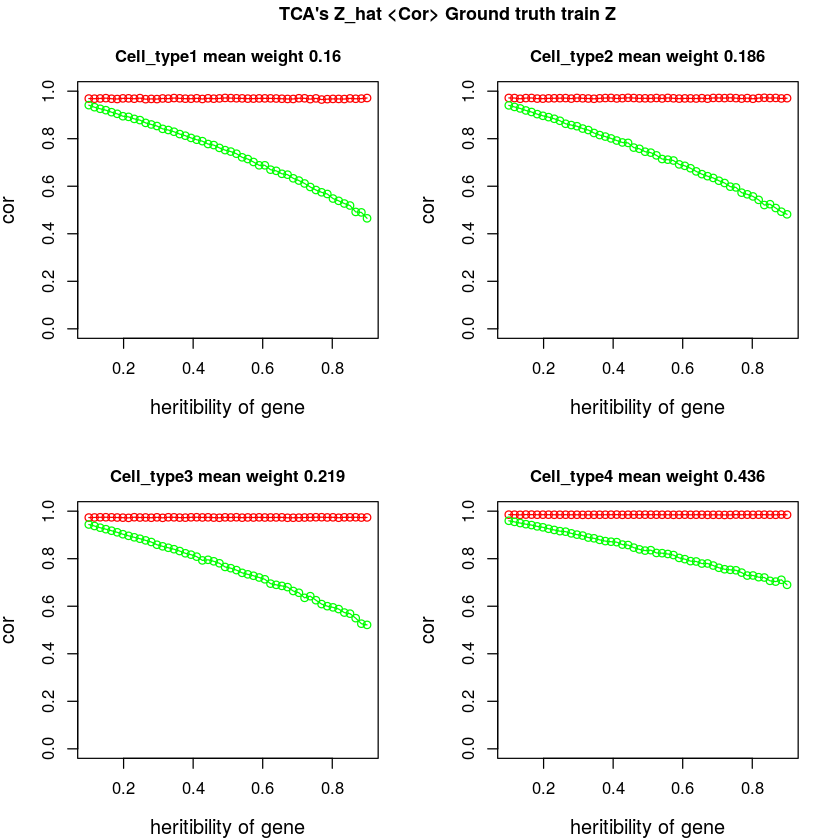

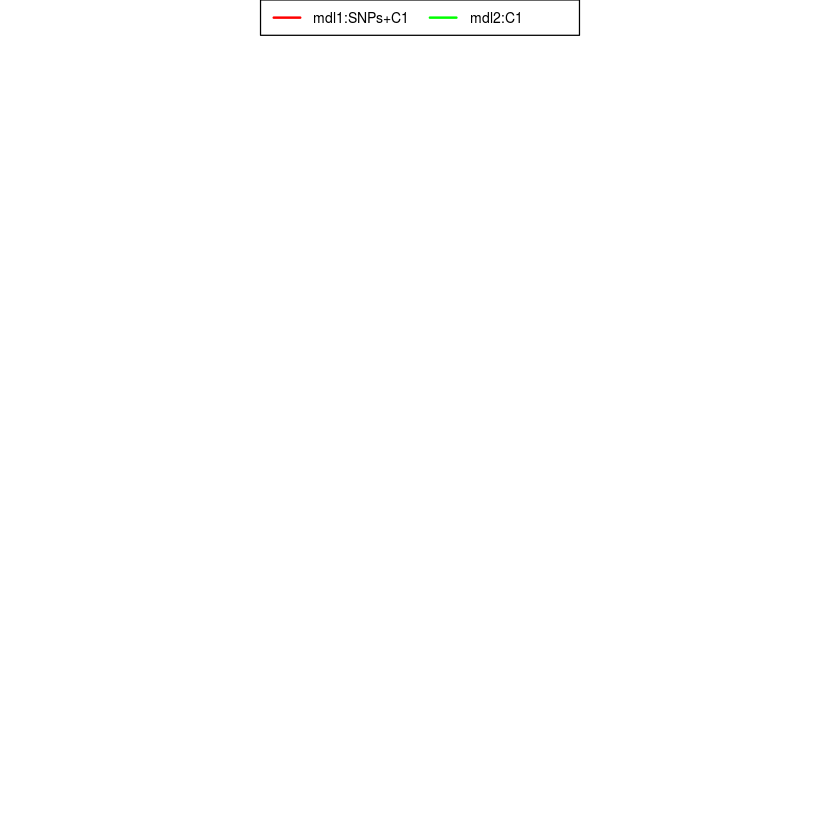

In [481]:
mean_weight = signif(apply(params$W,2,mean),digits=3)
Z_hat_cor_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$Z_hat_cor_tca))
Z_hat_cor_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$Z_hat_cor_tca))                                      

par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:length(params$cell_name)){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],Z_hat_cor_tca1[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],Z_hat_cor_tca2[,i],col='green',type='o')
    
}
mtext("TCA's Z_hat <Cor> Ground truth train Z",side=3,adj=6,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1:SNPs+C1','mdl2:C1'),
       col=c('red','green'),lwd=2,cex=0.7,horiz=TRUE)

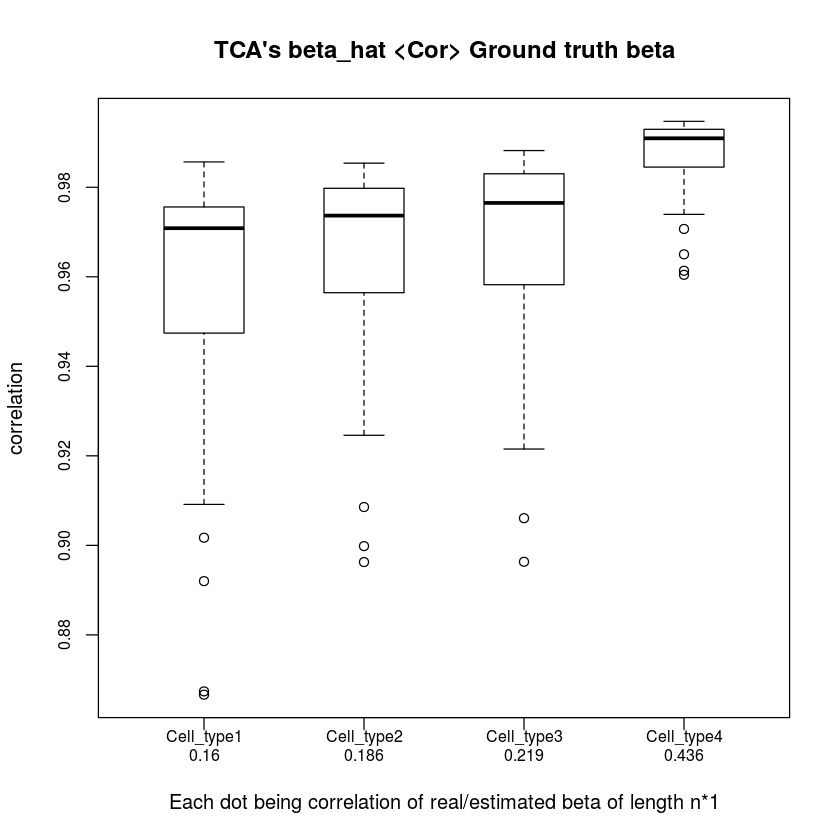

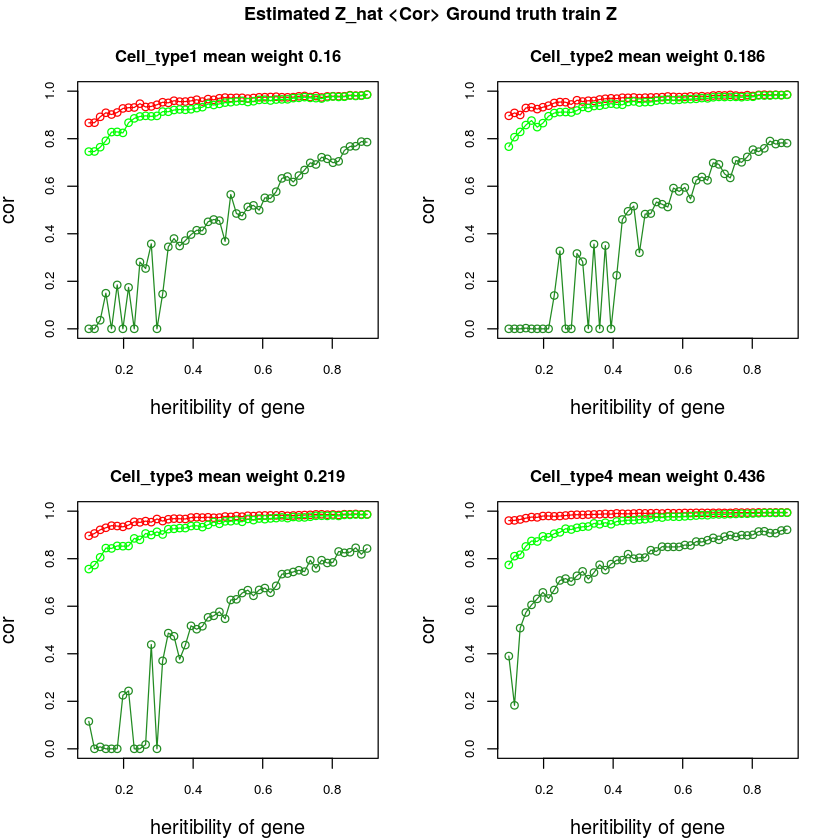

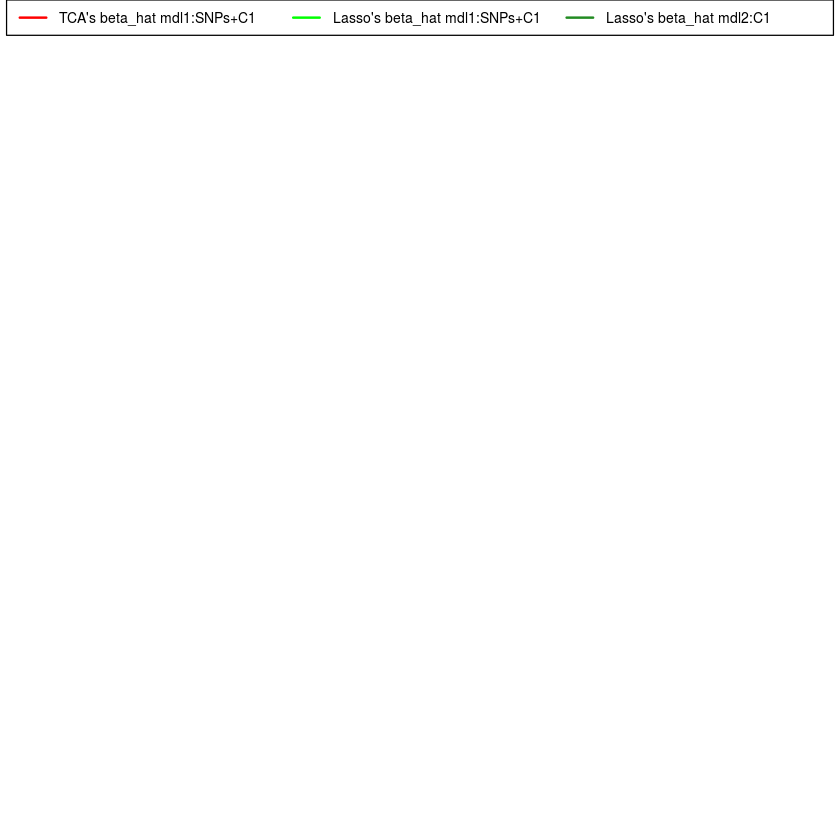

In [482]:
beta_hat_cor_tca = do.call(rbind,lapply(1:length(data),function(x) unlist(li[[x]]$s1$beta_hat_cor_tca)))
colnames(beta_hat_cor_tca) = paste(params$cell_name,mean_weight,sep='\n')
cor_beta_lasso_real1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$cor_beta_lasso_real))
cor_beta_lasso_real2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$cor_beta_lasso_real))
colnames(cor_beta_lasso_real1) = paste(params$cell_name,mean_weight,sep='\n')
colnames(cor_beta_lasso_real2) = paste(params$cell_name,mean_weight,sep='\n')
# Cell type weight and correlation
par(cex.axis=.8)
boxplot(beta_hat_cor_tca,ylab='correlation',
        xlab='Each dot being correlation of real/estimated beta of length n*1',
        boxwex=0.5,main="TCA's beta_hat <Cor> Ground truth beta")
# Heritibility and correlation
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:length(params$cell_name)){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],beta_hat_cor_tca[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    lines(params$her[i,],cor_beta_lasso_real1[,i],type='o',col='green')
    lines(params$her[i,],cor_beta_lasso_real2[,i],type='o',col='forestgreen')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
}
mtext("Estimated Z_hat <Cor> Ground truth train Z",side=3,adj=3.5,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c("TCA's beta_hat mdl1:SNPs+C1","Lasso's beta_hat mdl1:SNPs+C1","Lasso's beta_hat mdl2:C1"),
       col=c('red','green','forestgreen'),lwd=2,cex=0.7,horiz=TRUE)

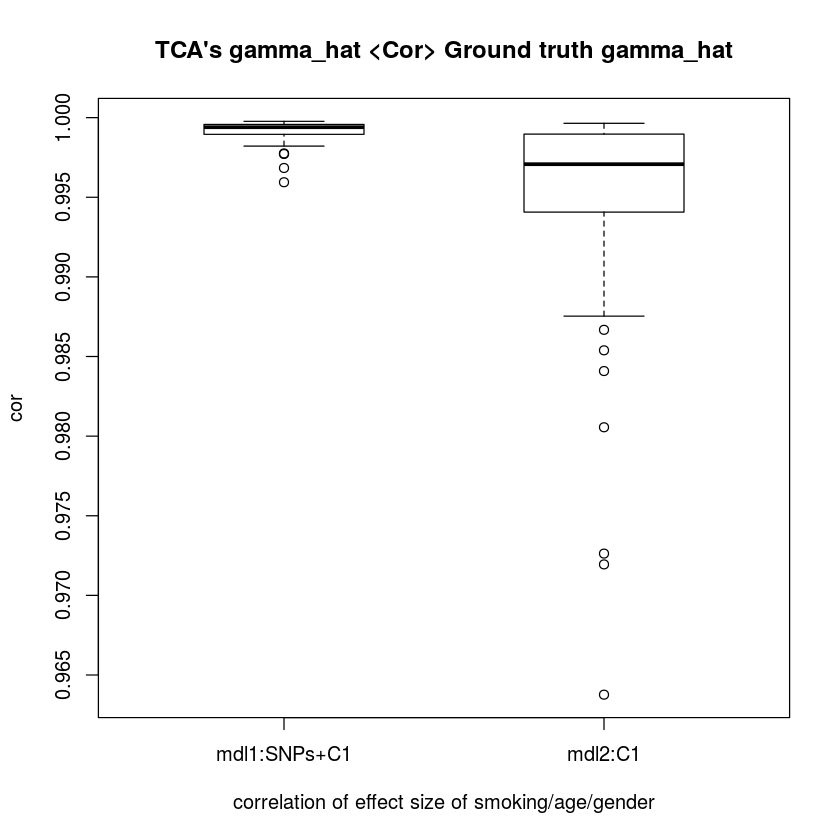

In [483]:
gamma_hat_cor_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$gamma_hat_cor_tca))
gamma_hat_cor_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$gamma_hat_cor_tca))
gamma_cor = cbind(gamma_hat_cor_tca1,gamma_hat_cor_tca2)
colnames(gamma_cor) = c('mdl1:SNPs+C1','mdl2:C1')
boxplot(gamma_cor,main="TCA's gamma_hat <Cor> Ground truth gamma_hat",
        ylab='cor',boxwex=0.5,
        xlab='correlation of effect size of smoking/age/gender')

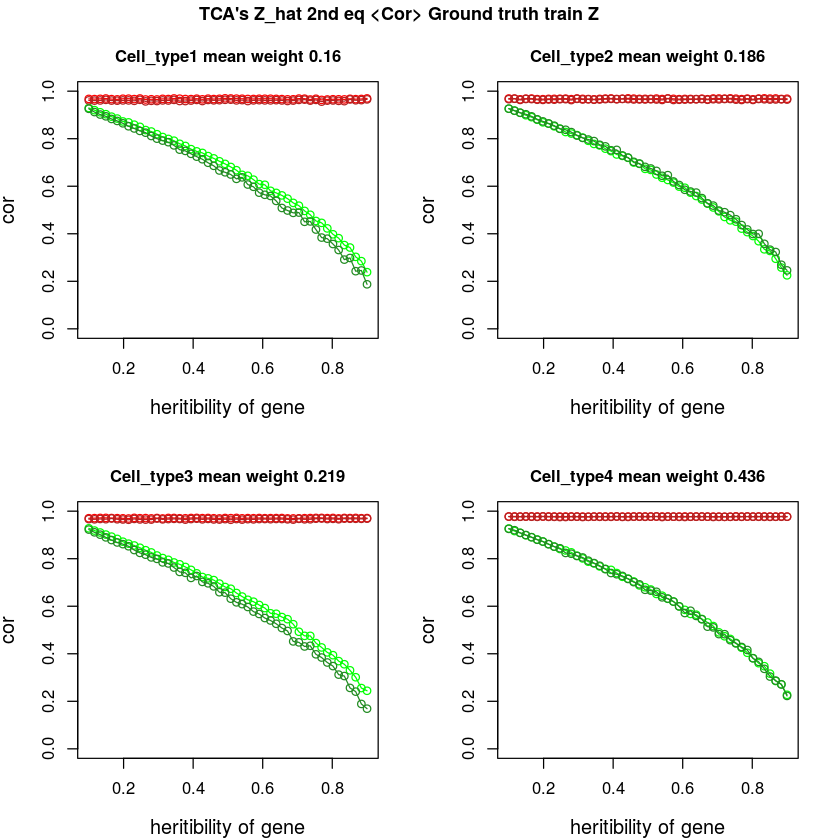

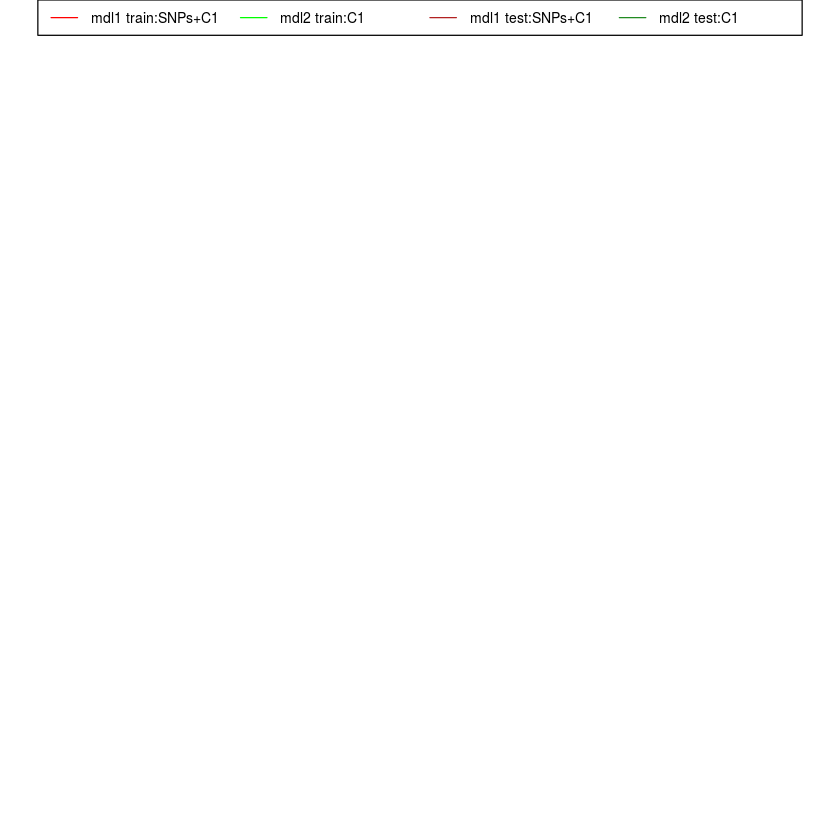

In [484]:
Z_hat_train_seq_eq_cor_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$Z_hat_train_second_eq_cor_tca))
Z_hat_train_seq_eq_cor_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$Z_hat_train_second_eq_cor_tca))
Z_hat_test_seq_eq_cor_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$Z_hat_test_second_eq_cor_tca))
Z_hat_test_seq_eq_cor_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$Z_hat_test_second_eq_cor_tca))

par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:params$K){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],Z_hat_train_seq_eq_cor_tca1[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],Z_hat_train_seq_eq_cor_tca2[,i],col='green',type='o')
    lines(params$her[i,],Z_hat_test_seq_eq_cor_tca1[,i],col='firebrick',type='o')
    lines(params$her[i,],Z_hat_test_seq_eq_cor_tca2[,i],col='forestgreen',type='o')
}
mtext("TCA's Z_hat 2nd eq <Cor> Ground truth train Z",side=3,adj=3,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1 train:SNPs+C1','mdl2 train:C1','mdl1 test:SNPs+C1','mdl2 test:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=1,cex=0.7,horiz=TRUE)

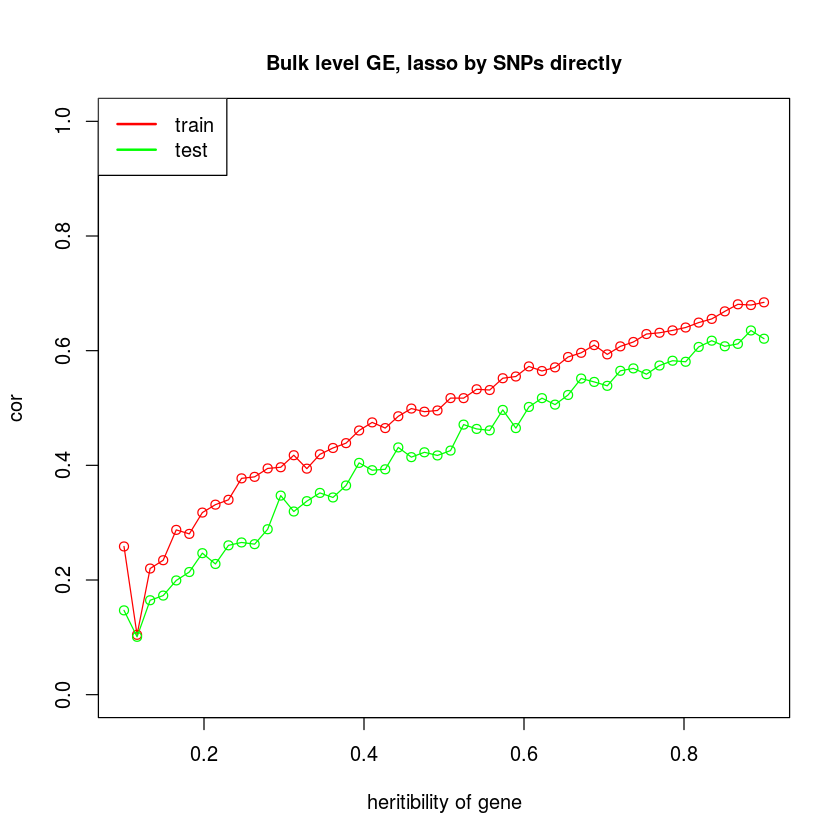

In [485]:
G_hat_train_cor_bulk = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$G_hat_train_cor_bulk))
G_hat_test_cor_bulk = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$G_hat_test_cor_bulk))
plot(params$her[1,],G_hat_train_cor_bulk,type='o',col='red',xlab='heritibility of gene',ylab='cor',ylim=c(0,1))
mtext("Bulk level GE, lasso by SNPs directly",font=2,line=1)
lines(params$her[1,],G_hat_test_cor_bulk,col='green',type='o')
legend(x='topleft',inset=0,legend=c('train','test'),
       col=c('red','green'),lwd=2,cex=1,horiz=FALSE)

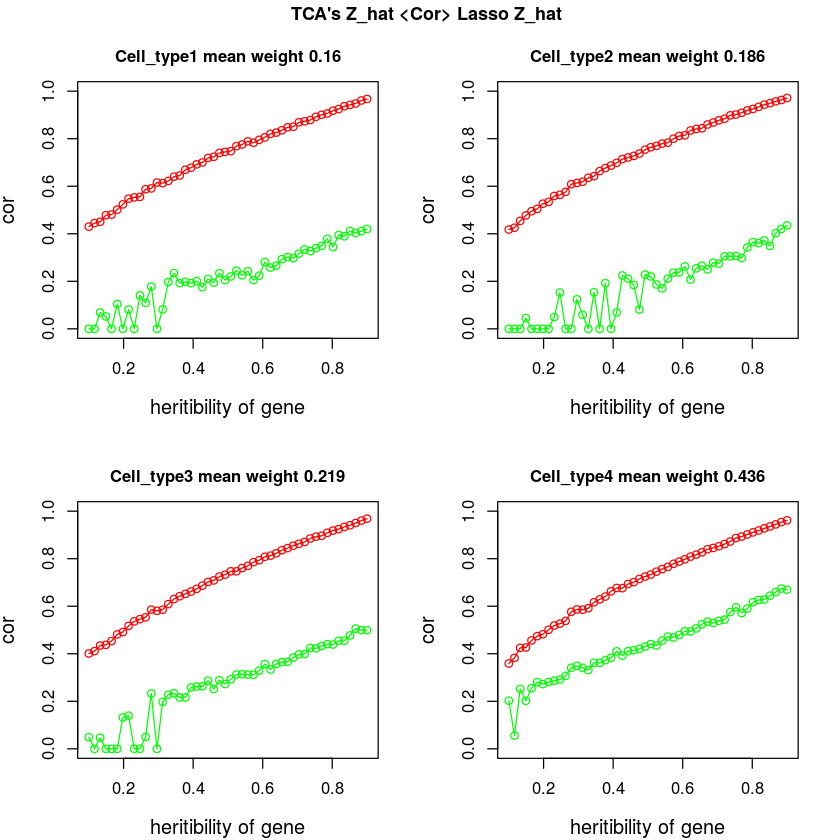

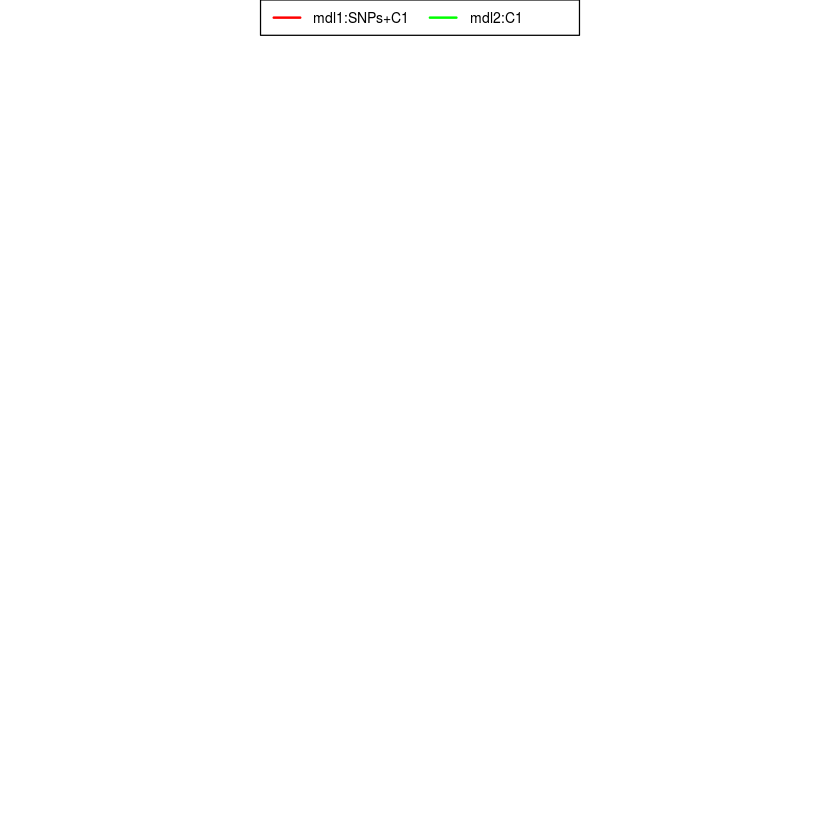

In [486]:
cor_lasso_tca1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$cor_lasso_tca))
cor_lasso_tca2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$cor_lasso_tca))
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:length(params$cell_name)){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],cor_lasso_tca1[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],cor_lasso_tca2[,i],col='green',type='o')
    
}
mtext("TCA's Z_hat <Cor> Lasso Z_hat",side=3,adj=-7,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1:SNPs+C1','mdl2:C1'),
       col=c('red','green'),lwd=2,cex=0.7,horiz=TRUE)

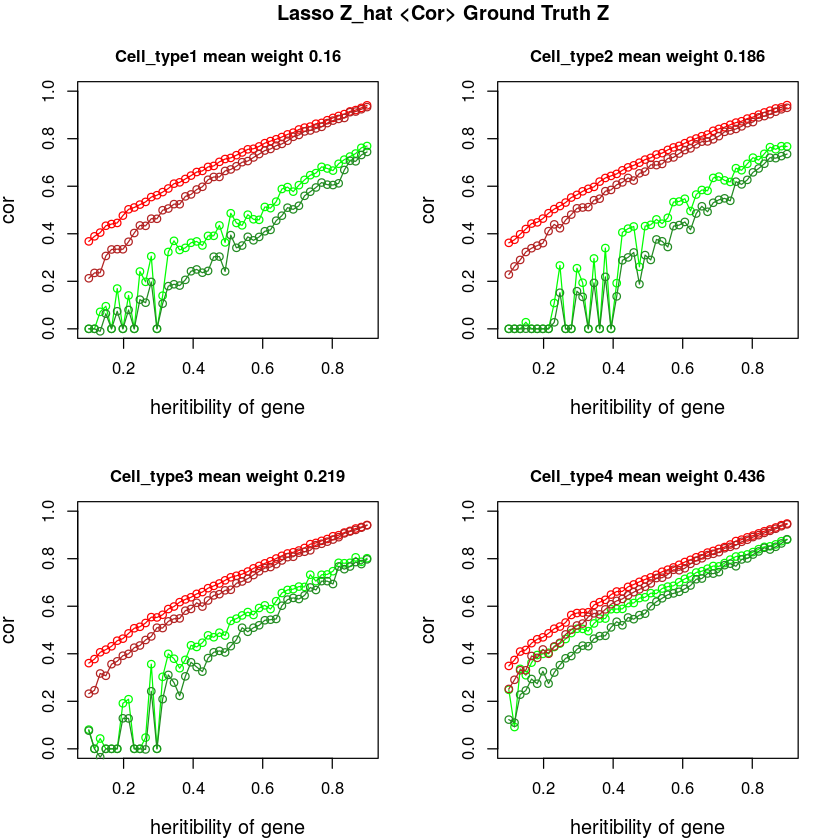

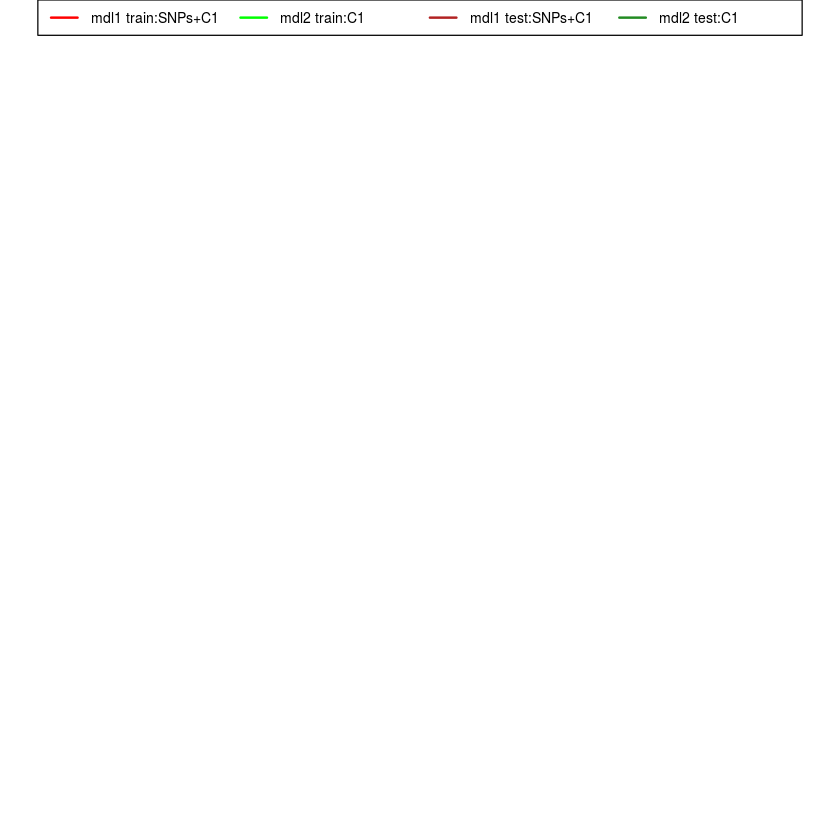

In [487]:
cor_lasso_real_train1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$cor_lasso_real_train))
cor_lasso_real_train2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$cor_lasso_real_train))
cor_lasso_real_test1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$cor_lasso_real_test))
cor_lasso_real_test2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$cor_lasso_real_test))
colnames(cor_lasso_real_train1) = paste(params$cell_name,'\n',mean_weight)
colnames(cor_lasso_real_train2) = paste(params$cell_name,'\n',mean_weight)
colnames(cor_lasso_real_test1) = paste(params$cell_name,'\n',mean_weight)
colnames(cor_lasso_real_test2) = paste(params$cell_name,'\n',mean_weight)                                            
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:length(params$cell_name)){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],cor_lasso_real_train1[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],cor_lasso_real_train2[,i],col='green',type='o')
    lines(params$her[i,],cor_lasso_real_test1[,i],col='firebrick',type='o')
    lines(params$her[i,],cor_lasso_real_test2[,i],col='forestgreen',type='o')
}
mtext("Lasso Z_hat <Cor> Ground Truth Z",side=3,adj=7,cex=1,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1 train:SNPs+C1','mdl2 train:C1','mdl1 test:SNPs+C1','mdl2 test:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=2,cex=0.7,horiz=TRUE)

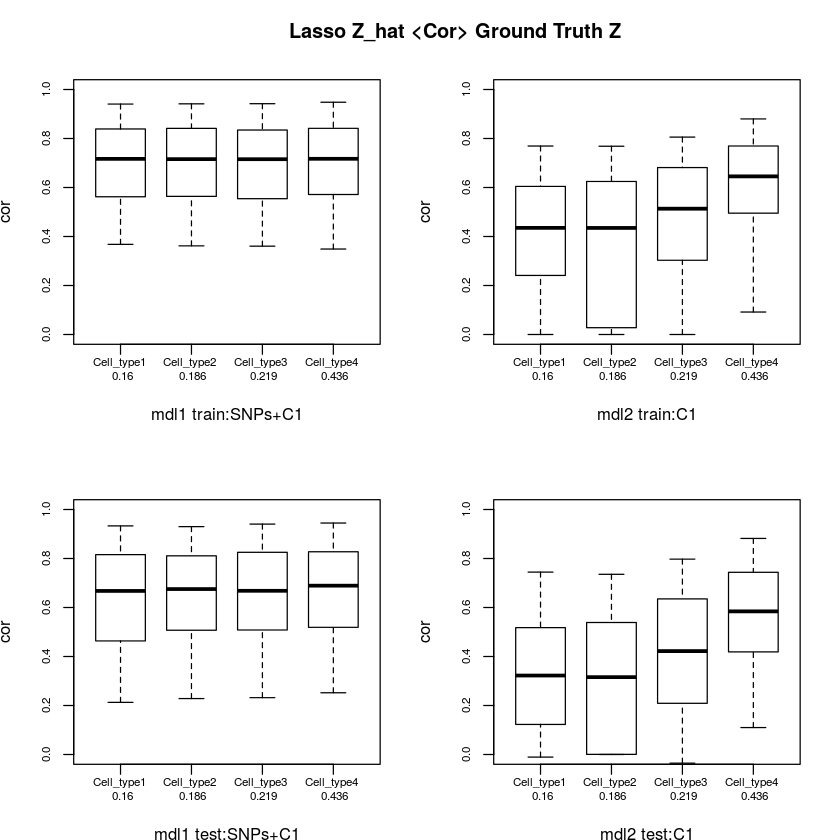

In [488]:
par(mar=c(0,0,0,0),cex.axis=.7)
par(mfrow=c(2,2),mar=c(3.8, 3.7, 4, 2))
boxplot(cor_lasso_real_train1,ylab='cor',
        xlab='mdl1 train:SNPs+C1',boxwex=0.7,ylim=c(0,1))
boxplot(cor_lasso_real_train2,ylab='cor',
        xlab='mdl2 train:C1',boxwex=0.7,ylim=c(0,1))
boxplot(cor_lasso_real_test1,ylab='cor',
        xlab='mdl1 test:SNPs+C1',ylim=c(0,1),boxwex=0.7)
boxplot(cor_lasso_real_test2,ylab='cor',
        xlab='mdl2 test:C1',boxwex=0.7,ylim=c(0,1))
mtext("Lasso Z_hat <Cor> Ground Truth Z",side=3,adj=8,cex=1,line=23,font=2)

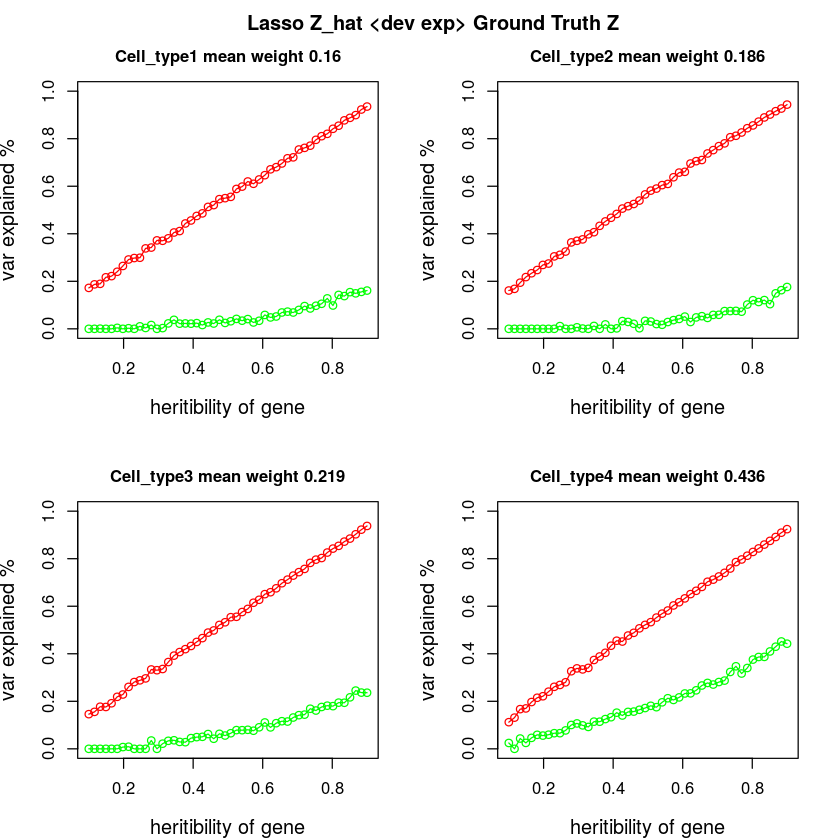

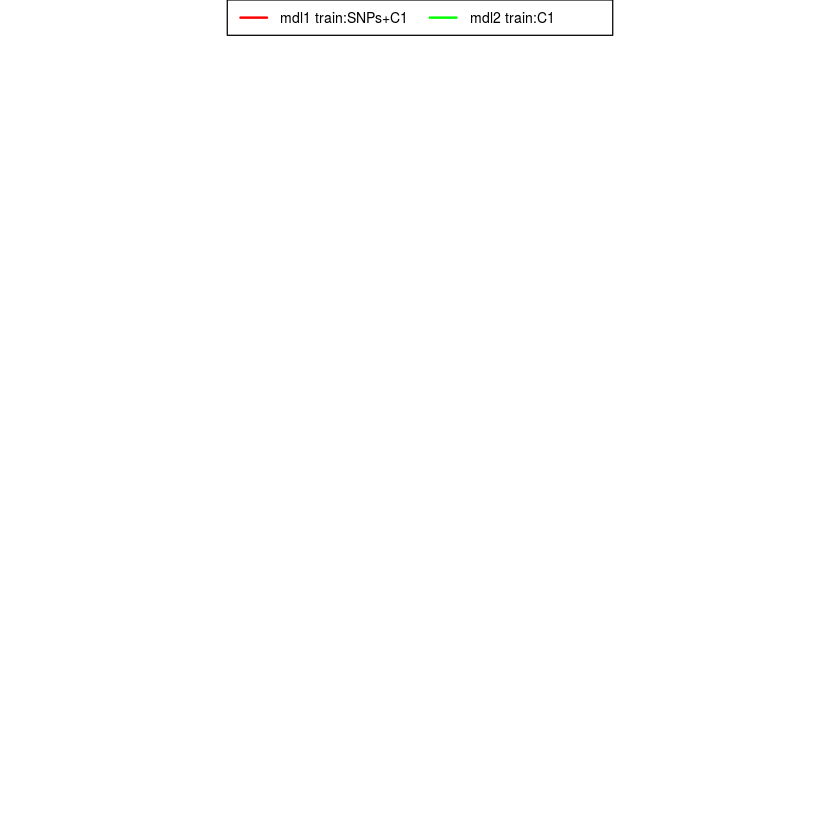

In [489]:
lasso_dev_rat1 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$dev_rat))
lasso_dev_rat2 = do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$dev_rat))
colnames(lasso_dev_rat1) = paste(params$cell_name,'\n',mean_weight)
colnames(lasso_dev_rat2) = paste(params$cell_name,'\n',mean_weight)
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:params$K){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],lasso_dev_rat1[,i],xlab='heritibility of gene',
         ylab='var explained %',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],lasso_dev_rat2[,i],col='green',type='o')
}
mtext("Lasso Z_hat <dev exp> Ground Truth Z",side=3,adj=3.5,cex=1,line=23.5,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1 train:SNPs+C1','mdl2 train:C1'),
       col=c('red','green'),lwd=2,cex=0.7,horiz=TRUE)

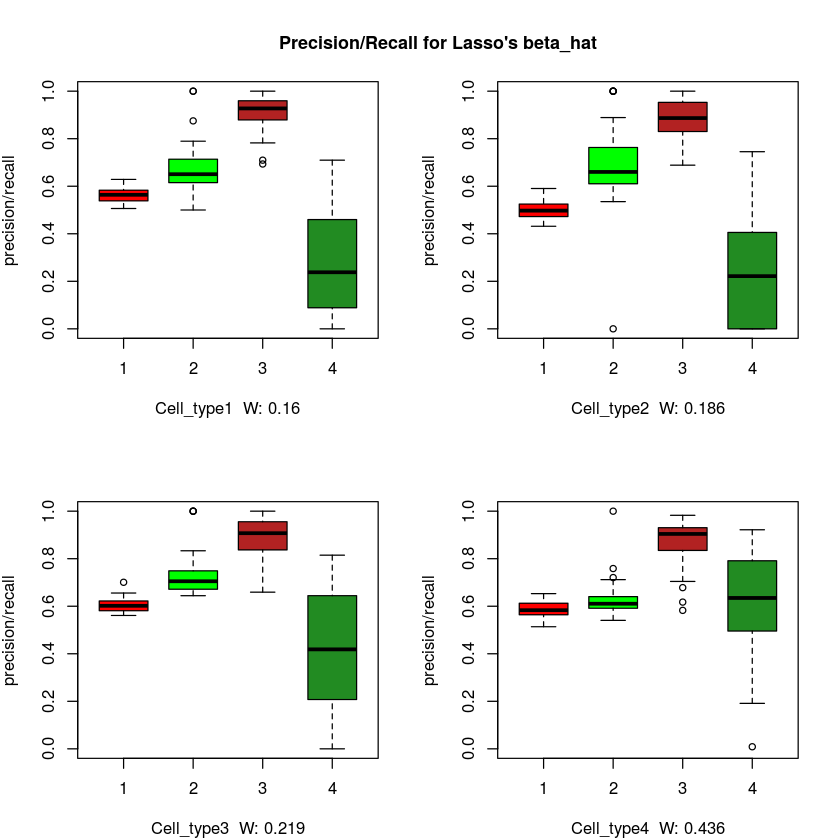

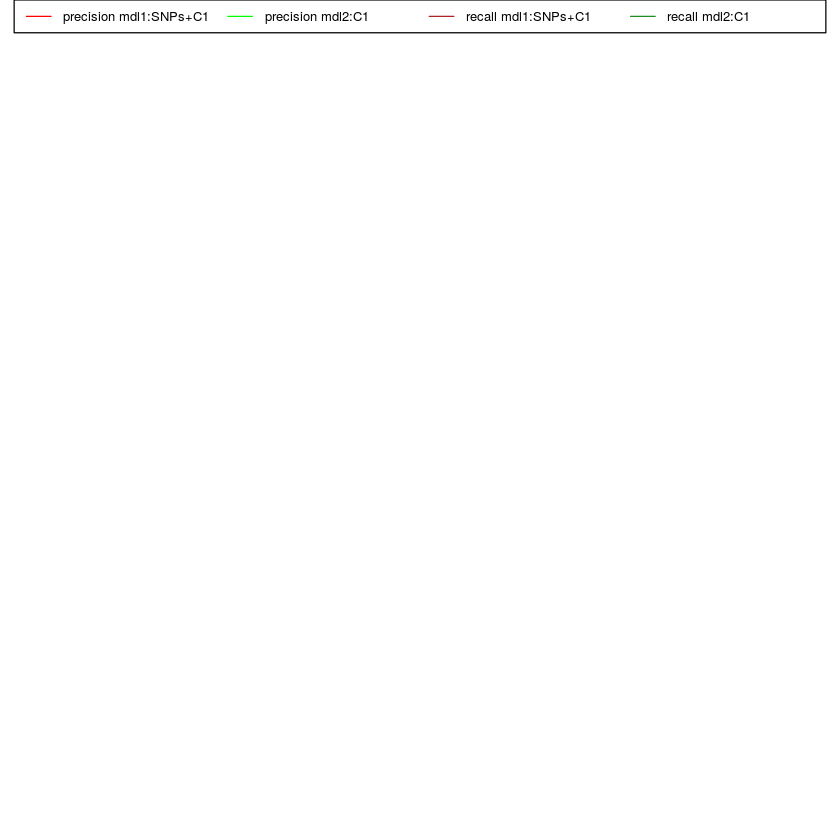

In [490]:
beta_precision_lasso1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$precision_lasso)),nrow=params$K)
beta_precision_lasso2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$precision_lasso)),nrow=params$K)
beta_recall_lasso1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$recall_lasso)),nrow=params$K)
beta_recall_lasso2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$recall_lasso)),nrow=params$K)
prec_rec_frame = lapply(1:params$K,function(x) t(rbind(beta_precision_lasso1[x,],beta_precision_lasso2[x,],beta_recall_lasso1[x,],beta_recall_lasso2[x,])))

par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=paste(params$cell_name,' W:',mean_weight)
for(i in 1:params$K){
    boxplot(prec_rec_frame[[i]],ylab='precision/recall',
        xlab=opts[i],boxwex=0.7,ylim=c(0,1),col=c('red','green','firebrick','forestgreen'))
}
mtext("Precision/Recall for Lasso's beta_hat",side=3,adj=12.5,cex=0.9,line=22.5,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('precision mdl1:SNPs+C1','precision mdl2:C1','recall mdl1:SNPs+C1','recall mdl2:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=1,cex=0.65,horiz=TRUE)

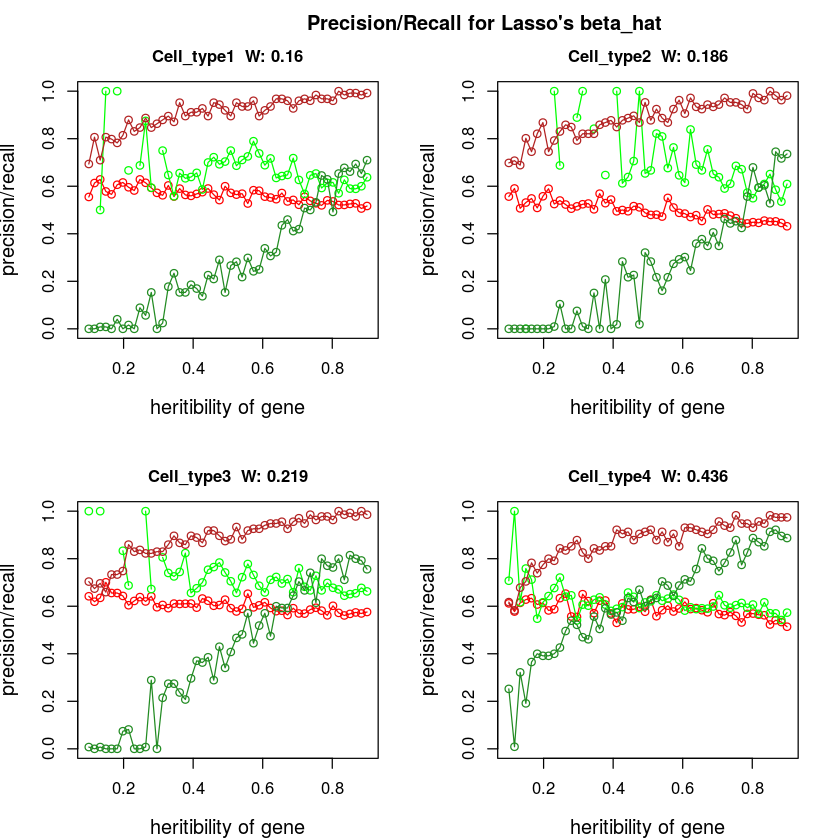

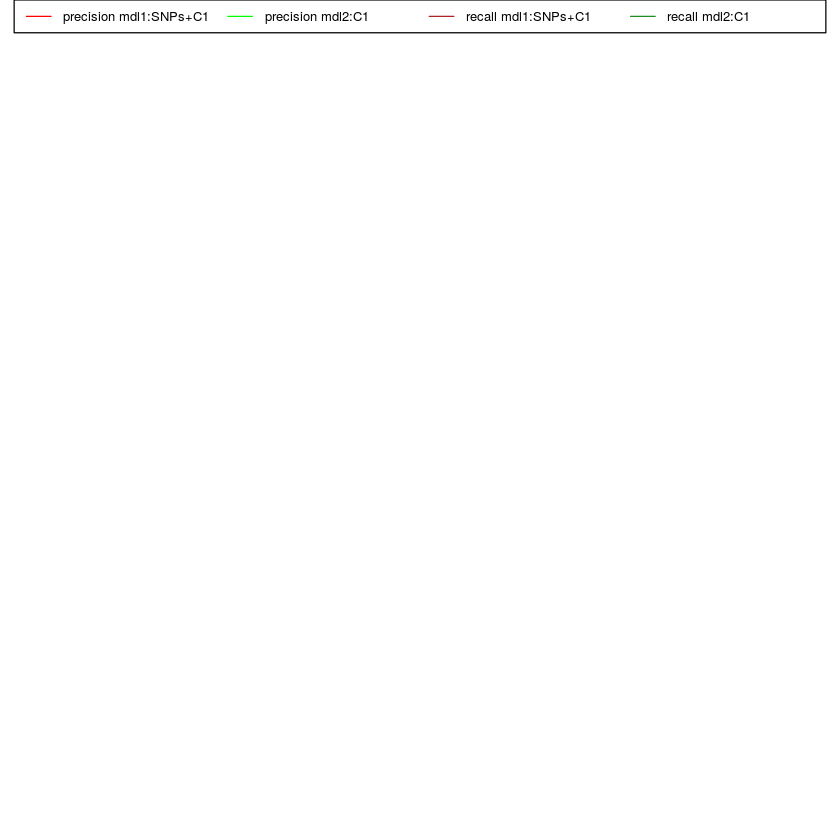

In [491]:
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
for(i in 1:params$K){
    plot(params$her[i,],prec_rec_frame[[i]][,1],xlab='heritibility of gene',
         ylab='precision/recall',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=opts[i],font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],prec_rec_frame[[i]][,2],col='green',type='o')
    lines(params$her[i,],prec_rec_frame[[i]][,3],col='firebrick',type='o')
    lines(params$her[i,],prec_rec_frame[[i]][,4],col='forestgreen',type='o')
}
mtext("Precision/Recall for Lasso's beta_hat",side=3,adj=3.5,cex=1,line=23.5,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('precision mdl1:SNPs+C1','precision mdl2:C1','recall mdl1:SNPs+C1','recall mdl2:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=1,cex=0.65,horiz=TRUE)

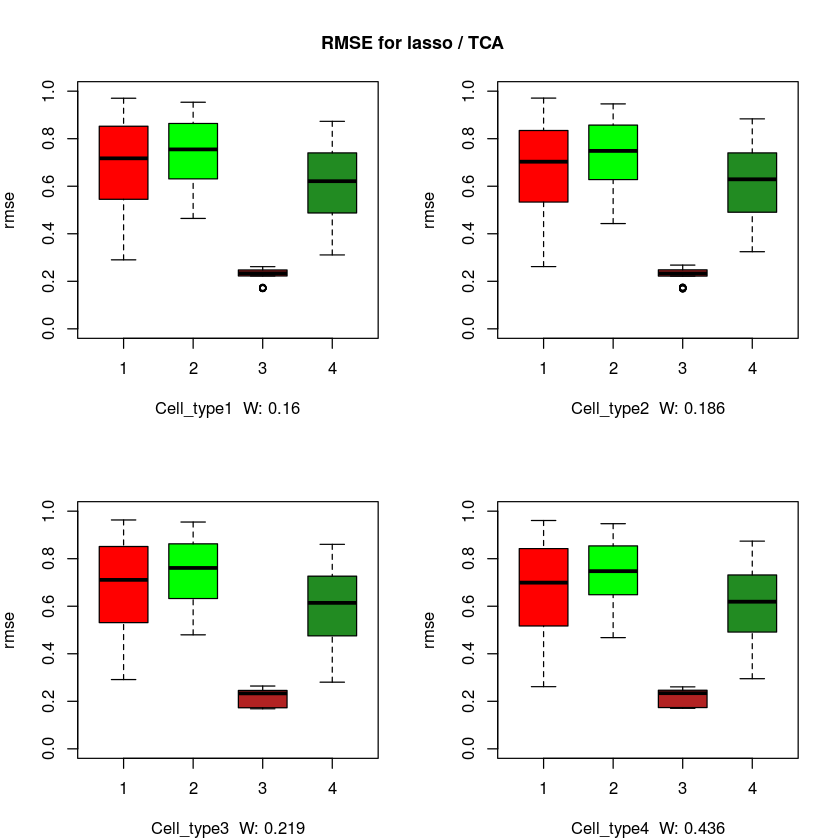

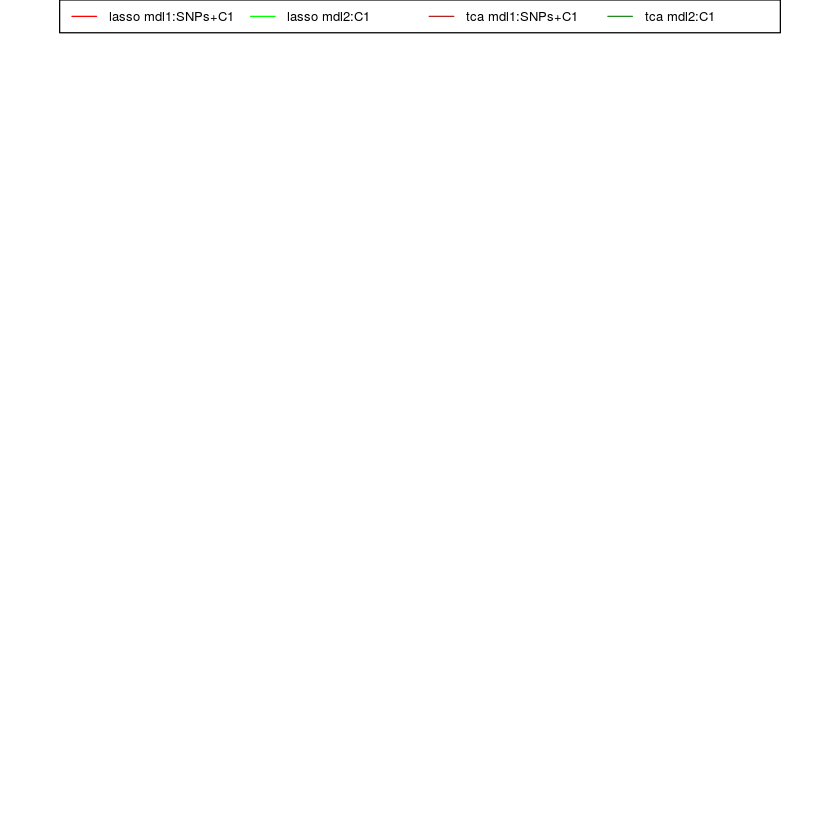

In [492]:
rmse_lasso1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$rmse_lasso)),nrow=params$K)
rmse_lasso2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$rmse_lasso)),nrow=params$K)
rmse_tca1 =　matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s1$rmse_tca)),nrow=params$K)
rmse_tca2 = matrix(do.call(rbind,lapply(1:length(data),function(x) li[[x]]$s2$rmse_tca)),nrow=params$K)
rmse_frame = lapply(1:params$K,function(x) t(rbind(rmse_lasso1[x,],rmse_lasso2[x,],rmse_tca1[x,],rmse_tca2[x,])))

par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=paste(params$cell_name,' W:',mean_weight)
for(i in 1:params$K){
    boxplot(rmse_frame[[i]],ylab='rmse',
        xlab=opts[i],boxwex=0.7,ylim=c(0,1),col=c('red','green','firebrick','forestgreen'))
}
mtext("RMSE for lasso / TCA",side=3,adj=-1.5,cex=0.9,line=22.5,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('lasso mdl1:SNPs+C1','lasso mdl2:C1','tca mdl1:SNPs+C1','tca mdl2:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=1,cex=0.65,horiz=TRUE)

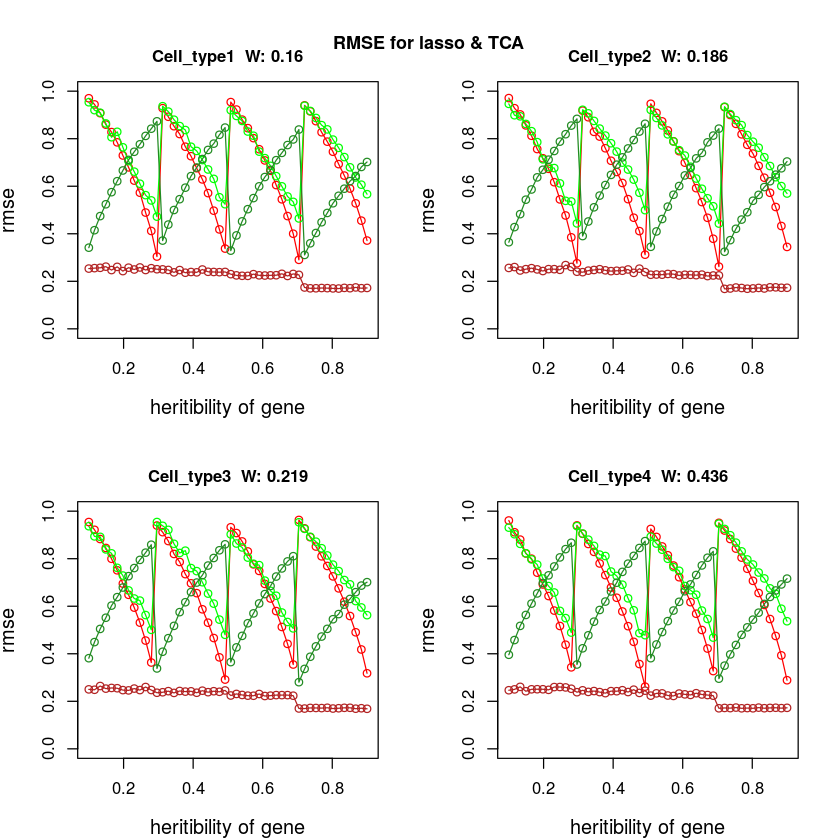

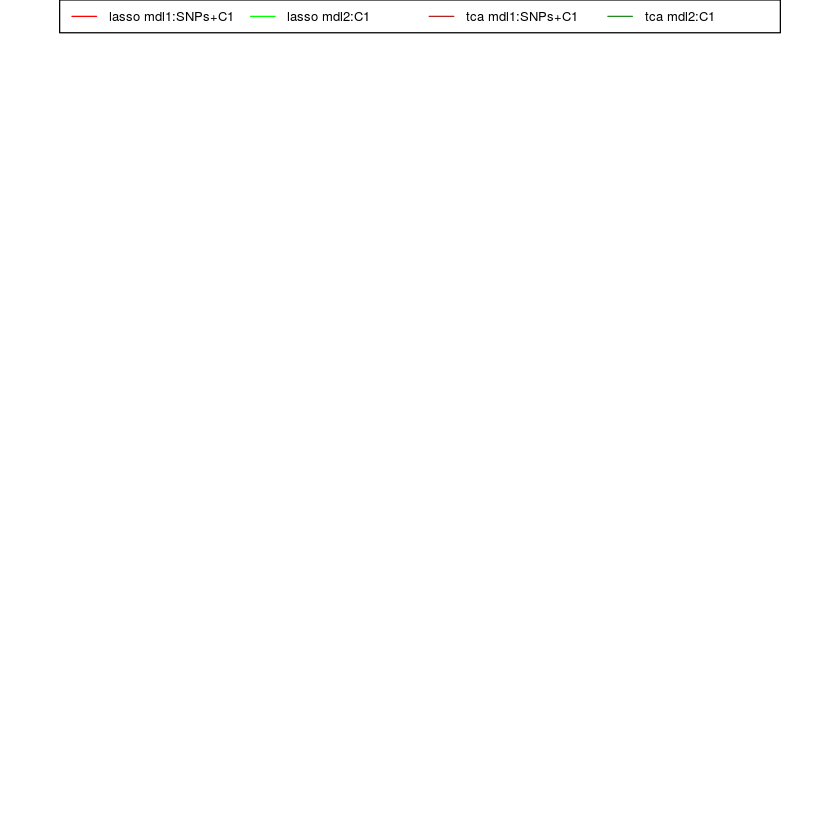

In [493]:
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
for(i in 1:params$K){
    plot(params$her[i,],rmse_frame[[i]][,1],xlab='heritibility of gene',
         ylab='rmse',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=opts[i],font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],rmse_frame[[i]][,2],col='green',type='o')
    lines(params$her[i,],rmse_frame[[i]][,3],col='firebrick',type='o')
    lines(params$her[i,],rmse_frame[[i]][,4],col='forestgreen',type='o')
}
mtext("RMSE for lasso & TCA",side=3,adj=-1.5,cex=0.9,line=22.5,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('lasso mdl1:SNPs+C1','lasso mdl2:C1','tca mdl1:SNPs+C1','tca mdl2:C1'),
       col=c('red','green','firebrick','forestgreen'),lwd=1,cex=0.65,horiz=TRUE)

In [349]:
)"
=================================================
This file is used to generate data from specific |
distribution to simulate the TCA+TWAS pipepine. |
=================================================
"

  "
  Generate SNPs and Gene Expression Data.
  @Params:
      N:          #samples
      D:          #SNP sequence length
      MAF:        #minor allele frequency
      M:          #gene expressions
      K:          #cell types
      p_slap:     sparsity. Proportion of gene not related to GE
      sigma_beta:         std of Beta (mu = X*beta+epsilon_{mu},beta gaussian)
      sigma_mu:           std of mu_z (mu = X*beta+epsilon_{mu},epsilon_mu gaussian)
      sigma_z:            std of Z (Z^{i}_{km}|mu^{i}_{km},epsilon^{i}_{km}~N{mu^{i}_{km},epsilon^{i}_{km})
      sigma_g:            std of Gene Expression
      alpha:              alpha for Cell Type Proportion, which follows dirichlet distribution
      Q                   number of traits
      train_proportion:   the proportion of training dataset
  @Shape information:
      This part tell us the shape information before we split them into training data and test data
      X:          N*D Matrix SNPs
      Z:          N*K*M Array cell type specific gene expression
      G:          M*N Matrix mixed gene expressions
      beta:       D*K*M Array effect size of SNPs on Z
      W:          N*K Matrix cell type proportion
      T:          Q Traits
      c1:         N*3
  @Returns:
      traing_data: ['X'=X, 'Z'=Z, 'G'=G, 'beta'=beta, 'W'=W, 'T'=T, 'c1'=c1]
      test_data:   ['X'=X, 'Z'=Z, 'G'=G, 'beta'=beta, 'W'=W, 'T'=T, 'c1'=c1]
  "


generate_data <- function(N=100,
                          D=2000,
                          MAF=0.1,
                          M=10,
                          K=6,
                          p_slab=0.5,
                          sigma_beta=0.3,
                          sigma_mu=0.3,
                          sigma_z=0.3,
                          sigma_g=0.01,
                          alpha=0.3,
                          Q=5,
                          train_proportion=0.7,
                          male_proportion=0.5,
                          smoking_proportion=0.2,
                          pc_num=2
                          ) {
    library('MCMCpack')
    
    #### names
    id_name = sapply(1:N, function(x) paste('SAMPLE',toString(x),sep = ''))
    cell_type=sapply(1:K, function(x) paste('Cell_type',x,sep = ''))
    snp_name=sapply(1:D, function(x) paste('SNP',toString(x),sep = ''))
    ge_name=sapply(1:M, function(x) paste('GE',toString(x),sep=''))
                   
    #### generate X
    X = sapply(1:D,function(x) rbinom(N, 2,0.1))
    while (qr(X)$rank<min(dim(X))){
        X = sapply(1:D,function(x) rbinom(N, 2,MAF))
    }
    
    colnames(X, do.NULL = TRUE, prefix = "col")
    colnames(X) <- snp_name
    rownames(X, do.NULL = TRUE, prefix = "col")
    rownames(X) <- id_name
    
    # mask a normal to form spikeslab
    beta = rnorm(D*K*M, mean=0, sd=sigma_beta)
    mask = rbinom(D*K*M, 1, 1-p_slab)
    beta = array(beta*mask, c(D,K,M))
    
    # \mu = X*\beta+\epsilon_mu
    epsilon_mu = array(rnorm(N*K*M, mean = 0, sd=sigma_mu), c(N,K,M))
    mu_z = lapply(c(1:M),function(x) X%*%beta[,,x])
    mu_z = array(as.numeric(unlist(mu_z)), dim=c(N,K,M)) + epsilon_mu
    # Simulate mu_jh that is shared across individuals
    mu <- array(runif(M*K, min=0, max=10), c(M,K))
    mu_stacked <- aperm(abind(lapply(1:N, function(x) mu), along = 3), c(3,2,1))
    mu <- mu_stacked
    # mu_z <- mu_stacked　# +mu_z
    
    #W = rdirichlet(N, rep(alpha,K))
    W <- rdirichlet(N, runif(K, 0, 1))
    colnames(W, do.NULL = TRUE, prefix = "col")
    colnames(W) <- cell_type
    rownames(W, do.NULL = TRUE, prefix = "col")
    rownames(W) <- id_name
  
    # Beta :QxM
    # T: NxQ
    # epsilon: NxQ
    
    ### generate C1 and C2
    male = matrix(rbinom(N, 1, 0.5),nrow=N)
    smoking = matrix(rbinom(N, 2, 0.2),nrow=N)
    smoking = (smoking - min(smoking))/(max(smoking))
    age =matrix(sapply(sapply(rnorm(N,50, 20), function(x) floor(x)), function(x)  if (x<0){x=20} else{x=x}),nrow=N) 
    age = (age-min(age))/(max(age)-min(age))
    c1= cbind(male, smoking, age)
    c2=matrix(rnorm(N*pc_num), nrow=N)
    rownames(c1, do.NULL = TRUE, prefix = "col")
    rownames(c1) <- id_name
    #colnames(c1, do.NULL = TRUE, prefix = "col")
    #colnames(c1) <- c('male','smoking','age', snp_name)
    #colnames(c1) <- snp_name
    rownames(c2, do.NULL = TRUE, prefix = "col")
    rownames(c2) <- id_name
    colnames(c2, do.NULL = TRUE, prefix = "col")
    colnames(c2) <- sapply(1:pc_num, function(x) paste('PC',toString(x),sep = ''))
                           
    ### Generating Z
    # sample z from mu_z and epsilon_za and C1
    # epsilon_z = array(rnorm(N*K*M,mean=0,sd=sigma_z), c(N,K,M))
    #sigma_z <- runif(K*M, 0, 1)
    #epsilon_z <- array(sapply(1:K*M, function(x) rnorm(N, mean=0, sd = sigma_z[x])),c(N,K,M))

    sigma_z = matrix(runif(M*K,0,0.3),M,K)
    epsilon_z = array(0,c(N,K,M))
    for(i in 1:M){
        for (j in 1:K){
            epsilon_z[,j,i] = rnorm(N, 0 ,sigma_z[i,j])
        }
    }
    Z = epsilon_z +mu_stacked
    dimnames(Z)[[1]] <- id_name
    dimnames(Z)[[2]] <- cell_type
    dimnames(Z)[[3]] <- ge_name
    # sample gama
    gama = array(sapply(1:K*M, function(x) runif(3, 0, 1)), dim = c(K, 3, M))
    c_gama = array(rep(0, N*K*M), c(N,K,M))
    for (i in 1:K) {
      c_gama[,i,] = c1 %*% gama[i,,]
    }
    Z = mu_z + Z# + c_gama
                        
    ### Generate Gene expressions
    G = sapply(c(1:M),function(x) rowSums(W*Z[,,c(x)]))
    epsilon_G = replicate(M,rnorm(N,mean=0,sd=sigma_g))
    G = G +epsilon_G
    T_t = runif(1)
    epsilon_G = replicate(Q,rnorm(N))*T_t*T_t
    beta_t = matrix(runif(Q*M),ncol=M)
    T = G%*%t(beta_t)+epsilon_G
    #generate delta
    delta = matrix(sapply(1:M*pc_num, function(x) runif(pc_num,0,1)), nrow = pc_num)
    c_delta = c2%*%delta
    G = G + c_delta
    
    rownames(G, do.NULL = TRUE, prefix = "col")
    rownames(G) <- id_name
    colnames(G, do.NULL = TRUE, prefix = "col")
    colnames(G) <- ge_name
    G = t(G)                      
    ### split into train and test data
    prop = floor(train_proportion*dim(X)[1])
    train_data = list('X'=X[c(1:prop),],
                      'Z'=Z[c(1:prop),,],
                      'G'=G[,c(1:prop)],
                      'beta'=beta,
                      'W'=W[c(1:prop),],
                      'T'=T[c(1:prop),],
                      'C1'=c1[c(1:prop),],
                      'C2'=c2[c(1:prop),],
                      'MU'=mu,
                      'SIGMA_Z'=sigma_z)
    test_data = list('X'=X[-c(1:prop),],
                     'Z'=Z[-c(1:prop),,],
                     'G'=G[,-c(1:prop)],
                     'beta'=beta,
                     'W'=W[-c(1:prop),],
                     'T'=T[-c(1:prop),],
                     'C1'=c1[-c(1:prop),],
                     'C2'=c2[-c(1:prop),],
                     'MU'=mu,
                     'SIGMA_Z'=sigma_z)
    
    return(list('train_data'=train_data,'test_data'=test_data))
}

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected ')'
1: )
    ^


# TCA Simulation
### I. Generate Data

In [290]:
D = 200
K = 4
M = 10
data=generate_data(N=1400,D=D,p_slab=0.5,M=M,K=K,MAF=0.18,train_proportion=0.7)
train_data=data[['train_data']]
test_data = data[['test_data']]
train_X=train_data[['X']]
train_W=train_data[['W']]
train_G = train_data[['G']]
train_c1=train_data[['C1']]
train_c2=train_data[['C2']]
train_Z=train_data[['Z']]
beta=train_data[['beta']]

test_X=test_data[['X']]
test_W=test_data[['W']]
test_G = test_data[['G']]
test_Z = test_data[['Z']]
test_c1=test_data[['C1']]
test_c2=test_data[['C2']]

In [291]:
print('whether D is a fat or a thin matrix')
N_ = dim(train_X)[1]
K_ = K
D_ = D
W_ = ncol(train_W)
if(N_ < (K_*D_+W_)){
    print('fat matrix, null space not null. semi definite. fail the test')
    paste(N_,'<',K_,'*',D_,'+',W_,'=',K_*D_+W_,sep=' ')
} else{
    print('tall matrx, null space might be zero. MAY/MAY NOT pass the test')
    paste(N_,'>',K_,'*',D_,'+',W_,'=',K_*D_+W_,sep=' ')
}

[1] "whether D is a fat or a thin matrix"
[1] "tall matrx, null space might be zero. MAY/MAY NOT pass the test"


[1] "979 > 4 * 200 + 4 = 804"

In [293]:
tca.mdl <- tca(X=t(as.data.frame(train_G[1,])), W=train_W,C1=train_X,verbose=TRUE,debug=TRUE)

INFO [2019-08-12 12:28:41] Starting tca...
INFO [2019-08-12 12:28:41] Validating input...
DEBUG [2019-08-12 12:28:41] Validating input types...
DEBUG [2019-08-12 12:28:41] Validating input stucture and values...
DEBUG [2019-08-12 12:28:41] Validating input conditions...
DEBUG [2019-08-12 12:28:41] Validating matrix dimensions...
DEBUG [2019-08-12 12:28:41] Validating the order of observations across matrices...
DEBUG [2019-08-12 12:28:41] Validating that W is non-negative and each row sums up to 1...
INFO [2019-08-12 12:28:41] Fitting the TCA model...
DEBUG [2019-08-12 12:28:41] Starting function 'tca.fit'...
INFO [2019-08-12 12:28:41] Fitting means and variances...
DEBUG [2019-08-12 12:28:41] Starting function 'tca.fit_means_vars'...
INFO [2019-08-12 12:28:41] Iteration 1 out of 10 internal iterations...
DEBUG [2019-08-12 12:28:41] Calculate W_norms and related quantities
DEBUG [2019-08-12 12:28:41] Estimate mus, deltas, gammas.
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 1

In [214]:
W = train_W# + rnm
k = ncol(W)
W_norms <- rowSums(W**2)**0.5
W_tilde <- W/t(repmat(W_norms,k,1))
C2 <- matrix(0, nrow=ncol(train_G), ncol=0)
train_X_ = train_X
n = nrow(W)
k = ncol(W)
p1 = ncol(train_X_)
C1_ = hadamard.prod(Reshape(Reshape(apply(W, 2, function(v) repmat(v,1,p1)), n*p1*k,1), n,p1*k), repmat(train_X_, 1, k))
C1_tilde <- C1_/t(repmat(W_norms,k*p1,1))
D = as.matrix(cbind(W_tilde,C2,C1_tilde))#5:ncol(C1_tilde)]))
Dmat <- t(D) %*% D
Dmat = round(Dmat,10)
print('W_tilde')
dim(W_tilde)
qr(W_tilde)$rank
print('C1_tilde')
dim(C1_tilde)
qr(C1_tilde)$rank
print('D')
dim(D)
qr(D)$rank
print('dependent columns of D')
#rankifremoved <- sapply(1:ncol(D), function (x) qr(D[,-x])$rank)
#rankifremoved
#which(rankifremoved == max(rankifremoved))
print('positive definite Dmat')
is.positive.definite(Dmat)

[1] "W_tilde"


[1] 979   4

[1] 4

[1] "C1_tilde"


[1] 979 800

[1] 800

[1] "D"


[1] 979 804

[1] 804

[1] "dependent columns of D"
[1] "positive definite Dmat"


[1] TRUE

In [215]:
rnm = matrix(rnorm(nrow(W)*ncol(W),mean=0,sd=0.1),nrow=nrow(W),ncol=ncol(W))

W = train_W# + rnm
k = ncol(W)
W_norms <- rowSums(W**2)**0.5
W_tilde <- W/t(repmat(W_norms,k,1))
C2 <- matrix(0, nrow=ncol(train_G), ncol=0)

# bad_rows = 10 34 40 80 117 121 217 226
bad_rows = array(0,ncol(train_X))
rankD = array(0,ncol(train_X))
dependent_row_number = list()
for (i in 1:ncol(train_X)){
    train_X_ = matrix(train_X[,i],nrow=nrow(train_X),ncol=1)
    n = nrow(W)
    k = ncol(W)
    p1 = ncol(train_X_)
    C1_ = hadamard.prod(Reshape(Reshape(apply(W, 2, function(v) repmat(v,1,p1)), n*p1*k,1), n,p1*k), repmat(train_X_, 1, k))
    C1_tilde <- C1_/t(repmat(W_norms,k*p1,1))
    D = as.matrix(cbind(W_tilde,C2,C1_tilde))#5:ncol(C1_tilde)]))
    Dmat <- t(D) %*% D
    Dmat = round(Dmat,10)
    if (!is.positive.definite(Dmat)){
        bad_rows[i] = 1
        rankD[i] = qr(D)$rank
        #rankifremoved <- sapply(1:ncol(D), function (x) qr(D[,-x])$rank)
        #dependent_row_number[length(dependent_row_number)+1] =  c(which(rankifremoved == max(rankifremoved)))
    }
}
print('all snps that fails postive definite tests')
# which(bad_rows==1)
rankD[rankD!=0] # Their D matrix's rank
# how many unique elements in 0/1/2/3 in these rows
unlist(apply(train_X[,c(which(bad_rows==1))],2,function(x) length(unique(x))))
#dependent_row_number
                                
                                
W = train_W + rnm
k = ncol(W)
W_norms <- rowSums(W**2)**0.5
W_tilde <- W/t(repmat(W_norms,k,1))
C2 <- matrix(0, nrow=ncol(train_G), ncol=0)

# bad_rows = 34, 10
bad_rows = array(0,ncol(train_X))
rankD = array(0,ncol(train_X))
dependent_row_number = list()
for (i in 1:ncol(train_X)){
    train_X_ = matrix(train_X[,i],nrow=nrow(train_X),ncol=1)
    n = nrow(W)
    k = ncol(W)
    p1 = ncol(train_X_)
    C1_ = hadamard.prod(Reshape(Reshape(apply(W, 2, function(v) repmat(v,1,p1)), n*p1*k,1), n,p1*k), repmat(train_X_, 1, k))
    C1_tilde <- C1_/t(repmat(W_norms,k*p1,1))
    D = as.matrix(cbind(W_tilde,C2,C1_tilde))#5:ncol(C1_tilde)]))
    Dmat <- t(D) %*% D
    Dmat = round(Dmat,10)
    if (!is.positive.definite(Dmat)){
        bad_rows[i] = 1
        rankD[i] = qr(D)$rank
        #rankifremoved <- sapply(1:ncol(D), function (x) qr(D[,-x])$rank)
        #dependent_row_number[length(dependent_row_number)+1] =  (which(rankifremoved == max(rankifremoved)))
    }

}
print('after random noise to weight, snps that fails')
which(bad_rows==1)
rankD[rankD!=0]

[1] "all snps that fails postive definite tests"


numeric(0)

integer(0)

[1] "after random noise to weight, snps that fails"


integer(0)

numeric(0)

### II. TCA model

In [199]:
D = 200
K = 4
M = 10
data=generate_data(N=5000,D=D,p_slab=0.5,M=M,K=K,MAF=0.18,train_proportion=0.7,sigma_g=0.3)
train_data=data[['train_data']]
test_data = data[['test_data']]
train_X=train_data[['X']]
train_W=train_data[['W']]
train_G = train_data[['G']]
train_c1=train_data[['C1']]
train_c2=train_data[['C2']]
train_Z=train_data[['Z']]
beta=train_data[['beta']]

test_X=test_data[['X']]
test_W=test_data[['W']]
test_G = test_data[['G']]
test_Z = test_data[['Z']]
test_c1=test_data[['C1']]
test_c2=test_data[['C2']]

In [200]:
rnm = matrix(rnorm(nrow(train_X)*ncol(train_X),mean=0,sd=0.1),nrow=nrow(train_X),ncol=ncol(train_X))
tca.mdl <- tca(X=train_G, W=train_W, C1=train_X, C2=train_c2,verbose=FALSE)
#tca.mdl <- tca(X=train_G, W=train_W,C1=train_c1,C2=train_c2,verbose=FALSE)
# tca.mdl <- tca(X=train_G, W=train_W,verbose=FALSE)
mu_hat=tca.mdl[['mus_hat']]
sigma_hat=tca.mdl[['sigmas_hat']]

# tca model summary statistics
z_hat=mu_hat#+sigma_hat

z_ = colSums(train_Z)/dim(train_Z)[[1]]
z_=t(z_)
cor.test(z_, z_hat)
cor(z_, z_hat)


	Pearson's product-moment correlation

data:  z_ and z_hat
t = 5.7698, df = 38, p-value = 1.178e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4724062 0.8202547
sample estimates:
      cor 
0.6833539 


,Cell_type1,Cell_type2,Cell_type3,Cell_type4
Cell_type1,0.9824847,-0.19472108,-0.28811985,-0.622327505
Cell_type2,-0.1487512,0.98390742,0.06534361,-0.212794786
Cell_type3,-0.4283274,0.09539096,0.92877144,0.001409613
Cell_type4,-0.3026210,-0.22275811,0.03637195,0.270610825


TCA models $$Z^{i}_{hj}\sim N(\mu_{hj},\sigma_{hj})$$ <br\> Same value across all samples. The test is the correlation between predicted $Z_{hj} \subseteq R_{MxK}$ and the real value

In [201]:
# correlation of the PCA prediction and the ground truth
# tca predicted z and the real z
for (gene_exp in c(1:dim(train_G)[[1]])){
    ge_name <- rownames(train_G)[gene_exp]
    tca.mdl.ge <- tcasub(tca.mdl,ge_name,log_file=NULL,verbose=FALSE)
    Z_hat <- tensor(t(train_G[gene_exp,]),tca.mdl.ge,log_file=NULL,verbose=FALSE)
    print(sapply(1:length(Z_hat), function(x) cor(unlist(Z_hat[x]),unlist(train_data[['Z']][,x,gene_exp]))))
}

[1] 0.8077872 0.7961064 0.8923311 0.2126965
[1] 0.6891876 0.6733700 0.8853929 0.1400134
[1] 0.55029543 0.49733547 0.74151487 0.01952763
[1] 0.5470466 0.5513850 0.7981101 0.1060033
[1] 0.609346194 0.540931856 0.816991929 0.008268835
[1] 0.7371731 0.6879743 0.8369080 0.0425594
[1] 0.6947268 0.6694169 0.8546228 0.1518756
[1] 0.562270931 0.550720472 0.887063255 0.003382284
[1] 0.78024756 0.79538859 0.85766763 0.07978051
[1] 0.7823855 0.7863335 0.8293514 0.1022495


In [202]:
colSums(tca.mdl$W)/dim(tca.mdl$W)[1]

Cell_type1 Cell_type2 Cell_type3 Cell_type4 
0.37815933 0.50887979 0.09997843 0.01298244

The above $MXK$ table is the correlation between tca predicted $z^{i}_{hj}$ and the real value.<br/>
Each $ELE_{hj}$ in the table is correlation between real $z_{hj} \subseteq R^{N}$ and tca predicted value  $z_{hj} \subseteq R^{N}$

In [203]:
cor.test(tca.mdl$sigmas_hat,train_data[['SIGMA_Z']])


	Pearson's product-moment correlation

data:  tca.mdl$sigmas_hat and train_data[["SIGMA_Z"]]
t = 0.74354, df = 38, p-value = 0.4617
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1991889  0.4157513
sample estimates:
      cor 
0.1197509 


In [204]:
beta_train = aperm(train_data[['beta']],c(3,1,2))
gamma_p = array(tca.mdl$gammas_hat, dim = c(M, D, K))
cor_gamma_beta = matrix(0,M,K)
for (i in 1:M){
    for (j in 1:K){
        cor_gamma_beta[i,j] <- cor(beta_train[i,,j],gamma_p[i,,j])
    }
}
cor_gamma_beta

0.9827177,0.9890665,0.9222846,0.2481555800
0.9780070,0.9861204,0.9191402,0.1426478149
0.9836049,0.9916022,0.8720735,-0.0005804779
0.9689516,0.9895263,0.8970043,0.1001337762
0.9850551,0.9867198,0.8930724,-0.0024709921
0.9793592,0.9864795,0.9039294,0.0290540722
0.9839140,0.9896388,0.9082814,0.1459397122
0.9735277,0.9864784,0.9235121,-0.0064327625
0.9813457,0.9890656,0.8990125,0.0737133954
0.9837014,0.9918791,0.8870136,0.0967320961


In [205]:
c_gamma = array(0, c(dim(train_X)[1],K,M))
for (i in 1:K) {
   c_gamma[,i,] = train_X %*% t(gamma[,,i])
}
p1 = c_gamma+train_data[['MU']][1:dim(c_gamma),,]
cor.test(p1,train_Z)

p_mu = aperm(abind(lapply(1:dim(train_X)[1], function(x) tca.mdl$mus_hat), along = 3), c(3,2,1))
p1 = c_gamma+p_mu
cor.test(p1,train_Z)

Warning message in 1:dim(c_gamma):
“numerical expression has 3 elements: only the first used”


	Pearson's product-moment correlation

data:  p1 and train_Z
t = 363.93, df = 140000, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6945396 0.6999231
sample estimates:
      cor 
0.6972412 



	Pearson's product-moment correlation

data:  p1 and train_Z
t = 235.37, df = 140000, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5286983 0.5362046
sample estimates:
      cor 
0.5324619 


In [206]:
c_gamma_test = array(0, c(dim(test_X)[1],K,M))
for (i in 1:K) {
   c_gamma_test[,i,] = test_X %*% t(gamma[,,i])
}
p1 = c_gamma_test+test_data[['MU']][1:dim(c_gamma_test),,]
cor.test(p1,test_Z)

p_mu = aperm(abind(lapply(1:dim(test_X)[1], function(x) tca.mdl$mus_hat), along = 3), c(3,2,1))
p1 = c_gamma_test+p_mu
cor.test(p1,test_Z)

Warning message in 1:dim(c_gamma_test):
“numerical expression has 3 elements: only the first used”


	Pearson's product-moment correlation

data:  p1 and test_Z
t = 235.44, df = 59998, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6888024 0.6971206
sample estimates:
      cor 
0.6929845 



	Pearson's product-moment correlation

data:  p1 and test_Z
t = 152.86, df = 59998, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5236305 0.5351485
sample estimates:
      cor 
0.5294139 


### iii. Lasso & correlation

In [207]:
corrs.bulk <- numeric(nrow(train_G))
corrs <- matrix(0,nrow(train_G),ncol(tca.mdl$W))
corrs.real <- matrix(0,nrow(train_G),ncol(tca.mdl$W))
corrs.beta <- matrix(0,nrow(train_G),ncol(tca.mdl$W))
G.scaled <- scale(train_X,center=TRUE,scale=TRUE)

corrs.test.bulk <- numeric(nrow(test_G))
corrs.test <- matrix(0,nrow(test_G),ncol(tca.mdl$W))
corrs.test.real <- matrix(0,nrow(test_G),ncol(tca.mdl$W))
G.test.scaled <- scale(test_X,center=TRUE,scale=TRUE)

ge_names = rownames(train_G)
# loop through 10 gene expressions
for (i in 1:nrow(train_G)){

    # run bulk data regression first    
    glmnet.mdl.X.cv <- cv.glmnet(x=G.scaled,y=train_G[i,],nfolds=5)
    glmnet.mdl.X <- glmnet(x=G.scaled,y=train_G[i,],lambda=glmnet.mdl.X.cv$lambda.min)
    beta.full.X <- as.numeric(glmnet.mdl.X$beta)
    # extract non zero predictors and recorrelate
    predictors.X <- colnames(G.scaled)[which(beta.full.X!=0)]
    beta.X <- as.matrix(c(glmnet.mdl.X$a0,as.matrix(glmnet.mdl.X$beta[predictors.X,])))
    bias_one <- numeric(nrow(G.scaled))+1
    pred <- cbind(bias_one,G.scaled[,predictors.X]) %*% beta.X
    corrs.bulk[i] <- cor.test(train_G[i,],pred)[['estimate']][['cor']]
    pred.test <- cbind(numeric(nrow(G.test.scaled))+1,G.test.scaled[,predictors.X]) %*% beta.X
    corrs.test.bulk[i] <- cor.test(test_G[i,],pred.test)[['estimate']][['cor']]
    cat('gene expression ',i,' cell type:')

    ge_name <- ge_names[i]
    tca.mdl.ge <- tcasub(tca.mdl,ge_name,log_file=NULL,verbose=FALSE)
    Z_hat <- tensor(t(train_G[i,]),tca.mdl.ge,log_file=NULL,verbose=FALSE)
    #Z_hat.test <- tensor(t(test_G[i,]),tca.mdl.ge,log_file=NULL,verbose=FALSE)
    # cell type specific
    for (h in 1:ncol(tca.mdl$W)){
        cat('..',h)
        celltype <- colnames(tca.mdl$W)[h]
        glmnet.mdl.cv <- cv.glmnet(x=G.scaled,y=Z_hat[[h]],standardize=FALSE,alpha=1,nfolds=5)
        glmnet.mdl <- glmnet(x=G.scaled,y=Z_hat[[h]],standardize=FALSE,alpha=1,lambda=glmnet.mdl.cv$lambda.min)
        beta.full <- as.numeric(glmnet.mdl$beta)
        predictors <- colnames(G.scaled)[which(beta.full != 0)]
        beta <- as.matrix(c(glmnet.mdl$a0,as.matrix(glmnet.mdl$beta[predictors,])))
        Z_hat.h.pred <- cbind(numeric(nrow(G.scaled))+1,G.scaled[,predictors]) %*% beta
        corrs[i,h] <- cor(t(Z_hat[[h]]),Z_hat.h.pred)
        corrs.real[i,h] <- cor(train_Z[,h,i],Z_hat.h.pred)
        corrs.beta[i,h] <- cor(train_data[['beta']][,h,i],beta.full)
        
        Z_hat.h.test.pred <- cbind(numeric(nrow(G.test.scaled))+1,G.test.scaled[,predictors]) %*% beta
        #corrs.test[i,h] <- cor(Z_hat.test[,h,i],Z_hat.h.test.pred)
        corrs.test.real[i,h] <- cor(test_Z[,h,i],Z_hat.h.test.pred)
    }
    print('')
}

gene expression  1  cell type:.. 1.. 2.. 3.. 4[1] ""
gene expression  2  cell type:.. 1.. 2.. 3.. 4[1] ""
gene expression  3  cell type:.. 1.. 2.. 3.. 4[1] ""
gene expression  4  cell type:.. 1.. 2.. 3.. 4[1] ""
gene expression  5  cell type:.. 1.. 2.. 3.. 4[1] ""
gene expression  6  cell type:.. 1.. 2.. 3.. 4[1] ""
gene expression  7  cell type:.. 1.. 2.. 3.. 4[1] ""
gene expression  8  cell type:.. 1.. 2.. 3.. 4[1] ""
gene expression  9  cell type:.. 1.. 2.. 3.. 4[1] ""
gene expression  10  cell type:.. 1.. 2.. 3.. 4[1] ""


In [208]:
corrs.bulk
corrs.test.bulk

[1] 0.4059471 0.3659653 0.3835874 0.4861961 0.5429394 0.4668902 0.3946165
 [8] 0.4154513 0.5731874 0.5329600

[1] 0.3195288 0.2592887 0.2623129 0.3757179 0.4434095 0.3862063 0.2512027
 [8] 0.3691013 0.4718344 0.4385758

For each Gene Expression, fit a lasso model from SNPs to bulk level mixed GE. Final predictions are made
with the none-zero lasso predictors. The above vector is correlation between lasso's predicion and real value. <br/> The uppe rine being train statistics, lowerline test statistics

In [209]:
corrs.real
#corrs.test.real

0.9453641,0.9612620,0.9070996,0.211916736
0.9179348,0.9415840,0.9013875,0.140598356
0.9193619,0.9008419,0.8403678,0.019771155
0.9026811,0.9157163,0.8767548,0.107094699
0.9245241,0.9118108,0.8712207,0.007210433
0.9368232,0.9428232,0.8671899,0.044628295
0.9318626,0.9463059,0.8840634,0.151823202
0.8982425,0.9151180,0.9099859,0.004055627
0.9422043,0.9627611,0.8768885,0.078692776
0.9397827,0.9632895,0.8577969,0.100069338


The above $MXK$ table is the correlation between lasso predicted $z^{i}_{hj}$ and the real value.<br/>
Prediction is made with none-zero effect size estimators. Each $ELE_{hj}$ in the table is correlation
between real $z_{hj} \subseteq R^{N}$ and lasso predicted value $z_{hj} \subseteq R^{N}$. NA occurs when
lasso prediction has almost-zero variance
<br/> The uppe rine being train statistics, lowerline test statistics

In [210]:
corrs.beta

0.9746481,0.9806891,0.9211536,0.247710540
0.9559923,0.9700569,0.9197128,0.143900746
0.9340943,0.9137575,0.8655679,-0.001816845
0.9290723,0.9341807,0.8940879,0.100036535
0.9524584,0.9375970,0.8913610,-0.004330933
0.9655738,0.9677115,0.9036112,0.031672880
0.9598441,0.9648873,0.9056257,0.144359043
0.9352416,0.9444519,0.9225054,-0.006015329
0.9709010,0.9795497,0.8962832,0.072365966
0.9717284,0.9822356,0.8835417,0.092661759


The above $MXK$ table is the correlation between lasso effect-size $\beta$ and the real $\beta$.<br/>
Each $ELE_{hj}$ in the table is correlation between real $\beta_{hj}$ and lasso predicted value. NA occurs when
lasso prediction has almost-zero variance

In [629]:
par(mfrow=c(2,2),mar=c(4, 3.8, 4, 2) + 0.1)
opts=params$cell_name
for(i in 1:length(params$cell_name)){
    heading = paste(opts[i],'mean weight',mean_weight[i],sep=' ')
    plot(params$her[i,],Z_hat_cor_tca1[,i],xlab='heritibility of gene',
         ylab='cor',cex.lab=1.2,ylim=c(0,1),yaxs='r',type='o',col='red')
    title(main=heading,font.main=2,cex.main=1,line=1,cex.lab=1)
    lines(params$her[i,],Z_hat_cor_tca2[,i],col='green',type='o')
    
}
mtext("TCA's Z_hat <Cor> Ground truth train Z",side=3,adj=6,cex=0.9,line=24,font=2)
par(mfrow=c(2,1),mar=c(0,0,0,0))
plot(1,type='n',axes=FALSE,xlab='',ylab='')
legend(x='top',inset=0,legend=c('mdl1:SNPs+C1','mdl2:C1'),
       col=c('red','green'),lwd=2,cex=0.7,horiz=TRUE)

Z_hat_tca = tensor(train_G,tca.mdl1,log_file=NULL,verbose=FALSE,debug=FALSE)
Z_hat_cor_tca = sapply(1:length(Z_hat), function(x) cor(unlist(Z_hat[x]),train_Z[,x]))
beta_hat_cor_tca = lapply(1:cell_type,function(x) 
    cor(beta[x,],tca.mdl1$gammas_hat[,grepl(paste("Cell_type",x,".G",sep=''),colnames(tca.mdl1$gammas_hat))]))
gamma_hat_cor_tca = cor(array(gamma_c1),
                        tca.mdl1$gammas_hat[,grepl('male|smok|age', colnames(tca.mdl1$gammas_hat))])
# second equation for tca prediction model 1
pred = cbind(train_X,train_c1)
Z_hat_train_second_eq_tca = sapply(1:cell_type,function(x) pred %*% tca.mdl1$gammas_hat[,((x-1)*dim(pred)[2]+1):(x*dim(pred)[2])])
z_hat_train_second_eq_cor_tca = diag(cor(train_Z,Z_hat_second_eq_tca))
# second equation for tca prediction model 2
# pred = train_c1
# Z_hat_second_eq_tca = sapply(1:cell_type,function(x) pred %*% tca.mdl2$gammas_hat[,((x-1)*dim(pred)[2]+1):(x*dim(pred)[2])])
# z_hat_second_eq_cor_tca = diag(cor(train_Z,Z_hat_second_eq_tca))

# second equation for tca prediction model 1 TEST
pred = cbind(test_X,test_c1)
Z_hat_test_second_eq_tca = sapply(1:cell_type,function(x) pred %*% tca.mdl1$gammas_hat[,((x-1)*dim(pred)[2]+1):(x*dim(pred)[2])])
z_hat_test_second_eq_cor_tca = diag(cor(test_Z,Z_hat_second_eq_tca))
                                  
# second equation for tca prediction model ２ TEST
# pred = test_c1
# Z_hat_test_second_eq_tca = sapply(1:cell_type,function(x) pred %*% tca.mdl２$gammas_hat[,((x-1)*dim(pred)[2]+1):(x*dim(pred)[2])])
# z_hat_test_second_eq_cor_tca = diag(cor(test_Z,Z_hat_second_eq_tca))

# Lasso
# run bulk data regression first
pred = cbind(train_X,train_c1)
glmnet.mdl.X.cv <- cv.glmnet(x=pred,y=t(train_G),nfolds=5)
glmnet.mdl.X <- glmnet(x=pred,y=t(train_G),lambda=glmnet.mdl.X.cv$lambda.min)
beta.full.X <- as.numeric(glmnet.mdl.X$beta)
# extract non zero predictors and recorrelate
predictors.X <- colnames(pred)[which(beta.full.X!=0)]
beta.X <- as.matrix(c(glmnet.mdl.X$a0,as.matrix(glmnet.mdl.X$beta[predictors.X,])))
bias_one <- numeric(nrow(pred))+1
G_hat_train_lasso <- cbind(bias_one,pred[,predictors.X]) %*% beta.X
G_hat_train_cor_bulk <- cor(t(train_G),G_hat_train_lasso)
pred = cbind(test_X,test_c1)
G_hat_test_lasso <- cbind(numeric(nrow(pred))+1,pred[,predictors.X]) %*% beta.X
G_hat_test_cor_bulk <- cor(t(test_G),G_hat_test_lasso)

#Z_hat.test <- tensor(t(test_G[i,]),tca.mdl.ge,log_file=NULL,verbose=FALSE)
# cell type specific
for (h in 1:ncol(tca.mdl1$W)){
    pred = cbind(train_X,train_c1)
    beta_cell_real = c(beta[h,],gamma_c1[h,])
    
    celltype <- colnames(tca.mdl$W)[h]
    glmnet.mdl.cv <- cv.glmnet(x=pred,y=Z_hat_tca[[h]],standardize=FALSE,alpha=1,nfolds=5)
    glmnet.mdl <- glmnet(x=pred,y=Z_hat_tca[[h]],standardize=FALSE,alpha=1,lambda=glmnet.mdl.cv$lambda.min)
    beta.full <- as.numeric(glmnet.mdl$beta)
    predictors <- colnames(pred)[which(beta.full != 0)]
    beta_lasso <- as.matrix(c(glmnet.mdl$a0,as.matrix(glmnet.mdl$beta[predictors,])))
    Z_hat_train_lasso <- cbind(numeric(nrow(pred))+1,pred[,predictors]) %*% beta_lasso
    corrs <- cor(t(Z_hat_tca[[h]]),Z_hat_train_lasso)
    corrs.real <- cor(train_Z,Z_hat_train_lasso)
    corrs.beta <- cor(beta_cell_real,beta.full)
    
    pred = cbind(test_X,test_c1)
    Z_hat_test_lasso <- cbind(numeric(nrow(pred))+1,pred[,predictors]) %*% beta_lasso
    #corrs.test[i,h] <- cor(Z_hat.test[,h,i],Z_hat.h.test.pred)
    corrs.test.real <- cor(test_Z,Z_hat_test_lasso)
}